### Demographics API

Below we have the code that retrieves the data from the  Mechanical Turk Tracker Demographics API.

In [1]:
# Render our plots inline
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
!sudo -H pip3 install -U pip matplotlib pandas numpy seaborn xlwt

Requirement already up-to-date: pip in /usr/local/lib/python3.5/dist-packages (19.3.1)
Requirement already up-to-date: matplotlib in /usr/local/lib/python3.5/dist-packages (3.0.3)
Requirement already up-to-date: pandas in /usr/local/lib/python3.5/dist-packages (0.24.2)
Requirement already up-to-date: numpy in /usr/local/lib/python3.5/dist-packages (1.17.3)
Requirement already up-to-date: seaborn in /usr/local/lib/python3.5/dist-packages (0.9.0)
Requirement already up-to-date: xlwt in /usr/local/lib/python3.5/dist-packages (1.3.0)


In [3]:
import pandas as pd
import matplotlib
import numpy as np
import seaborn as sns

In [4]:

df = pd.read_csv("mturk_surveys.csv")
df.drop(df.columns[0], axis=1, inplace=True) # drop the "index" column
# We now transform our API answer into a flat table
# and set the right data types
df["hit_answered_date"]=pd.to_datetime(df["hit_answered_date"])
df["hit_creation_date"]=pd.to_datetime(df["hit_creation_date"])
df["household_income"]=df["household_income"].astype("category")
df["household_size"]=df["household_size"].astype("category")
df["location_country"]=df["location_country"].astype("category")
df["marital_status"]=df["marital_status"].astype("category")
df['date'] = pd.to_datetime(df['hit_answered_date'].apply(lambda x : x.date()))
df['time'] = df['hit_answered_date'].dt.round('min').apply(lambda x : x.time())
df.dtypes

gender                             object
hit_answered_date          datetime64[ns]
hit_creation_date          datetime64[ns]
household_income                 category
household_size                   category
location_city                      object
location_country                 category
location_region                    object
marital_status                   category
post_to_completion_secs           float64
worker_id                          object
year_of_birth                       int64
date                       datetime64[ns]
time                               object
dtype: object

In [5]:
import datetime
import time

minDate = min(df['hit_answered_date'])
maxDate = max(df['hit_answered_date'])

# The following are for setting up the x-axis in the plots that
# show demographics over time
min_x = minDate.toordinal()
max_x = maxDate.toordinal()
ticks = 6
steps = (max_x-min_x)/ticks

days = (maxDate - minDate).days
print(minDate)
print(maxDate)
print(days)

2015-03-26 11:47:28.877000
2019-11-04 15:42:46.243000
1684


In [6]:
df['ttl'] = (df['hit_answered_date'] - df['hit_creation_date']).dt.total_seconds()

In [7]:
df['hour'] = df['hit_creation_date'].dt.hour

In [8]:
df['dow'] = df['hit_creation_date'].dt.dayofweek

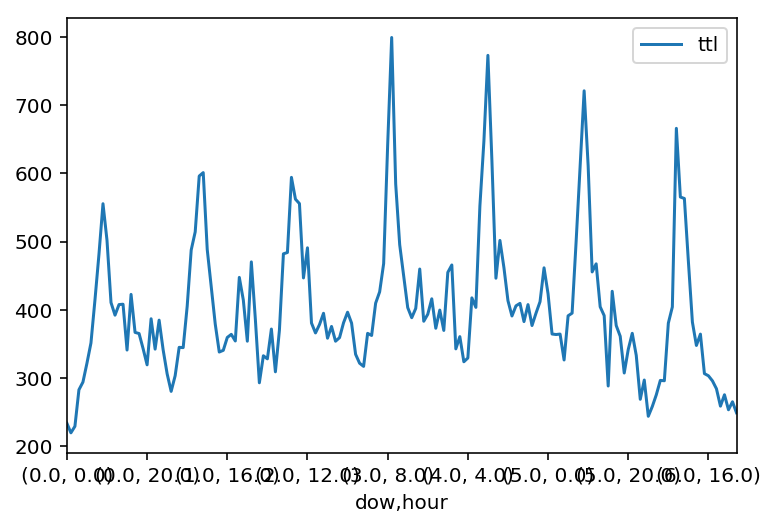

In [9]:
df.pivot_table(
    index=['dow','hour'],
    values='ttl',
    aggfunc = np.median
).plot()

# sns.violinplot(data=df, x='hour', y='ttl', ylim=(0,100))

In [10]:
print(min_x)
print(max_x)

735683
737367


In [11]:
len(set(df.worker_id))

68956

In [12]:
# Fix a data quality issue
#fix = list(df[df.gender=='Female'].index)[0]
#df = df.set_value(fix, 'gender', 'female')

In [13]:
# df.head(5)

### Exploratory plots

In [14]:
!sudo -H pip3 install -U matplotlib

Requirement already up-to-date: matplotlib in /usr/local/lib/python3.5/dist-packages (3.0.3)


In [15]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
mpl.__version__

'3.0.3'

In [16]:
# !sudo -H pip3 install -U seaborn

In [17]:
import seaborn as sns
sns.__version__

'0.9.0'

In [18]:
mpl.rc("figure", figsize=(16, 8))
mpl.rcParams.update({'font.size': 22})
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
sns.set_style("whitegrid")

#### Countries of the workers

In [19]:
# Let's see the top countries
country = 100* df['location_country'].value_counts() / len(df)

In [20]:
pd.DataFrame(country.head(30))

location_country
US         72.621344
IN         18.589289
CA          1.373493
GB          0.960028
IT          0.429486
DE          0.375261
BR          0.370332
PH          0.316723
VE          0.285913
FR          0.268660
ES          0.209505
ZZ          0.197798
MX          0.185474
AU          0.152816
KE          0.128168
AE          0.118925
RO          0.109682
NL          0.106601
TR          0.105369
JP          0.100439
NG          0.099823
TH          0.096126
ID          0.093045
RU          0.092429
PT          0.089964
GR          0.087499
IE          0.084418
MK          0.082570
UA          0.073327
NZ          0.070862

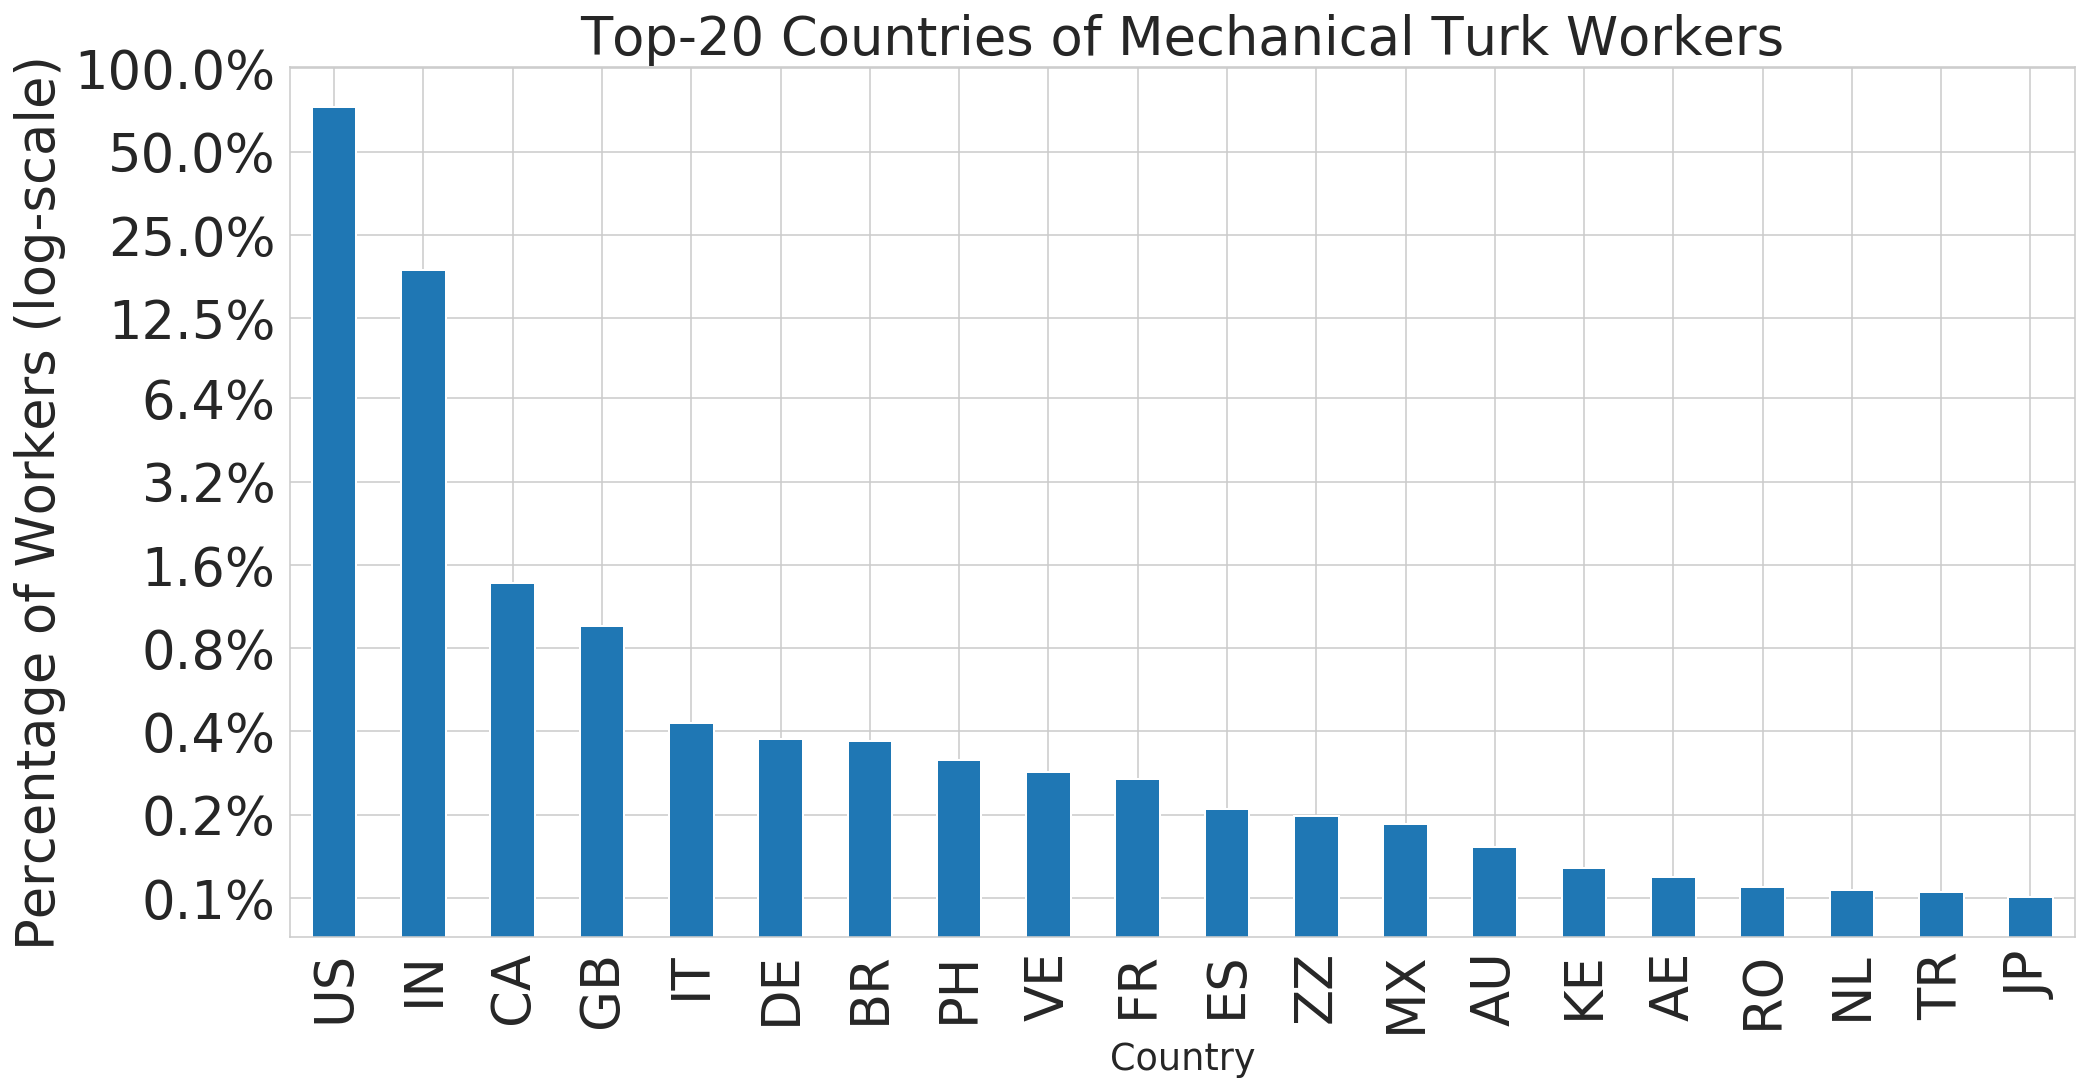

In [21]:
ax = country.head(20).plot.bar(log=True, fontsize='large', color=sns.color_palette(n_colors=1))
ax.set_title("Top-20 Countries of Mechanical Turk Workers", fontsize='large')
ax.set_xlabel("Country", fontsize='small')
ax.set_ylabel("Percentage of Workers (log-scale)", fontsize='large')

fmt = '%.1f%%' # Format you want the ticks, e.g. '40%'
yticks = mtick.FormatStrFormatter(fmt)
ax.yaxis.set_major_formatter(yticks)
ax.set_yticks([0.1, 0.2, 0.4, 0.8, 1.6, 3.2, 6.4, 12.5, 25, 50, 100])
#ax.yaxis.set_major_formatter(mtick.PercentFormatter())

fig = ax.get_figure()
fig.savefig('plots/countries.pdf', bbox_inches='tight')

In [22]:
country_table = pd.crosstab(index=df.date, columns=df.location_country, 
                            values='worker_id', aggfunc=np.count_nonzero, normalize='index')
# country_table

In [23]:
def time_plot(data, title, filename, confidence=True, legend=False):
        # Compute the mean, and the 10%, 25%, 75%, and 90% percentile
    # Values calculated over a rolling 30-day window
    # Plot lines are smoothed using a 7-day exponential weighted window
    m = data.rolling(window=30).mean().ewm(span=7).mean()
    s1 = data.rolling(window=30).quantile(quantile=0.25).ewm(span=7).mean()
    s2 = data.rolling(window=30).quantile(quantile=0.75).ewm(span=7).mean()
    #s3 = country_table['US'].rolling(window=30).quantile(quantile=0.1).ewm(span=7).mean()
    #s4 = country_table['US'].rolling(window=30).quantile(quantile=0.9).ewm(span=7).mean()

    ax = m.plot(fontsize='small')
    if confidence:
        ax = s1.plot(fontsize='small', color='#bbbbff', linestyle = '--', ax = ax)
        ax = s2.plot(fontsize='small', color='#bbbbff', linestyle = '--', ax = ax)
        
        
    #ax = s3.plot(fontsize='small', color='#eeeeff', linestyle = '--', ax = ax)
    #ax = s4.plot(fontsize='small', color='#eeeeff', linestyle = '--', ax = ax)

    ax.set_title(title, fontsize='large')
    ax.set_ylabel("Percentage", fontsize='small')
    ax.set_xlabel("Date", fontsize='small')
    
    fmt = '%3.1f%%' # Format you want the ticks, e.g. '40%'
    yticks = mtick.FormatStrFormatter(fmt)
    ax.yaxis.set_major_formatter(yticks)
    
    if legend:
        ax.legend( fontsize='small', fancybox=True, frameon = True)
        

            
          
    #ax.xaxis.set_ticks(np.arange(min_x, max_x, steps))
    #ax.yaxis.set_ticks(np.arange(0.55, 0.91, 0.05))
    fig = ax.get_figure()
    fig.savefig(filename, bbox_inches='tight')
    
    return ax


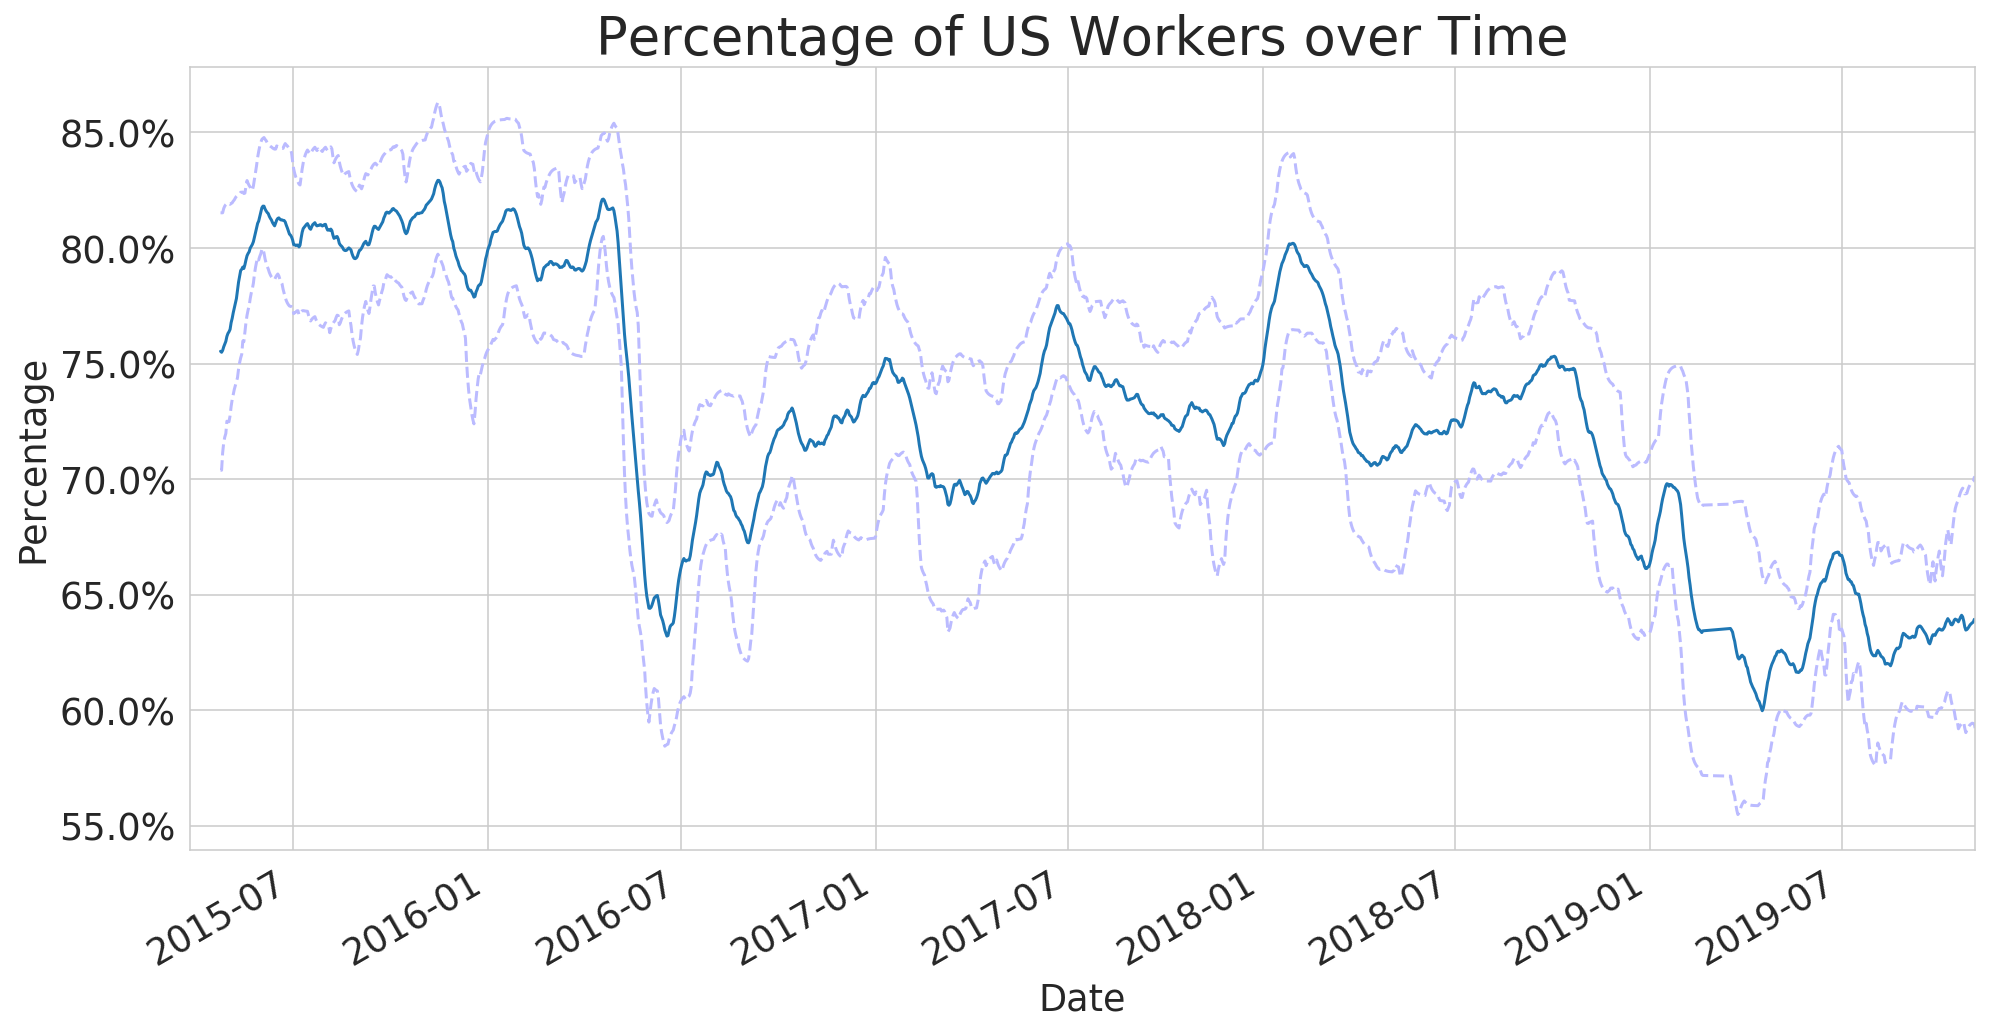

In [24]:
time_plot(100*country_table['US'], 'Percentage of US Workers over Time', 'plots/country-us.pdf')

In [25]:
country_table_time = pd.crosstab(index=df.time, 
                                 columns=df.location_country, 
                                 values='worker_id', 
                                 aggfunc=np.count_nonzero, 
                                 normalize='index')
country_table_time.sort_index(inplace=True)

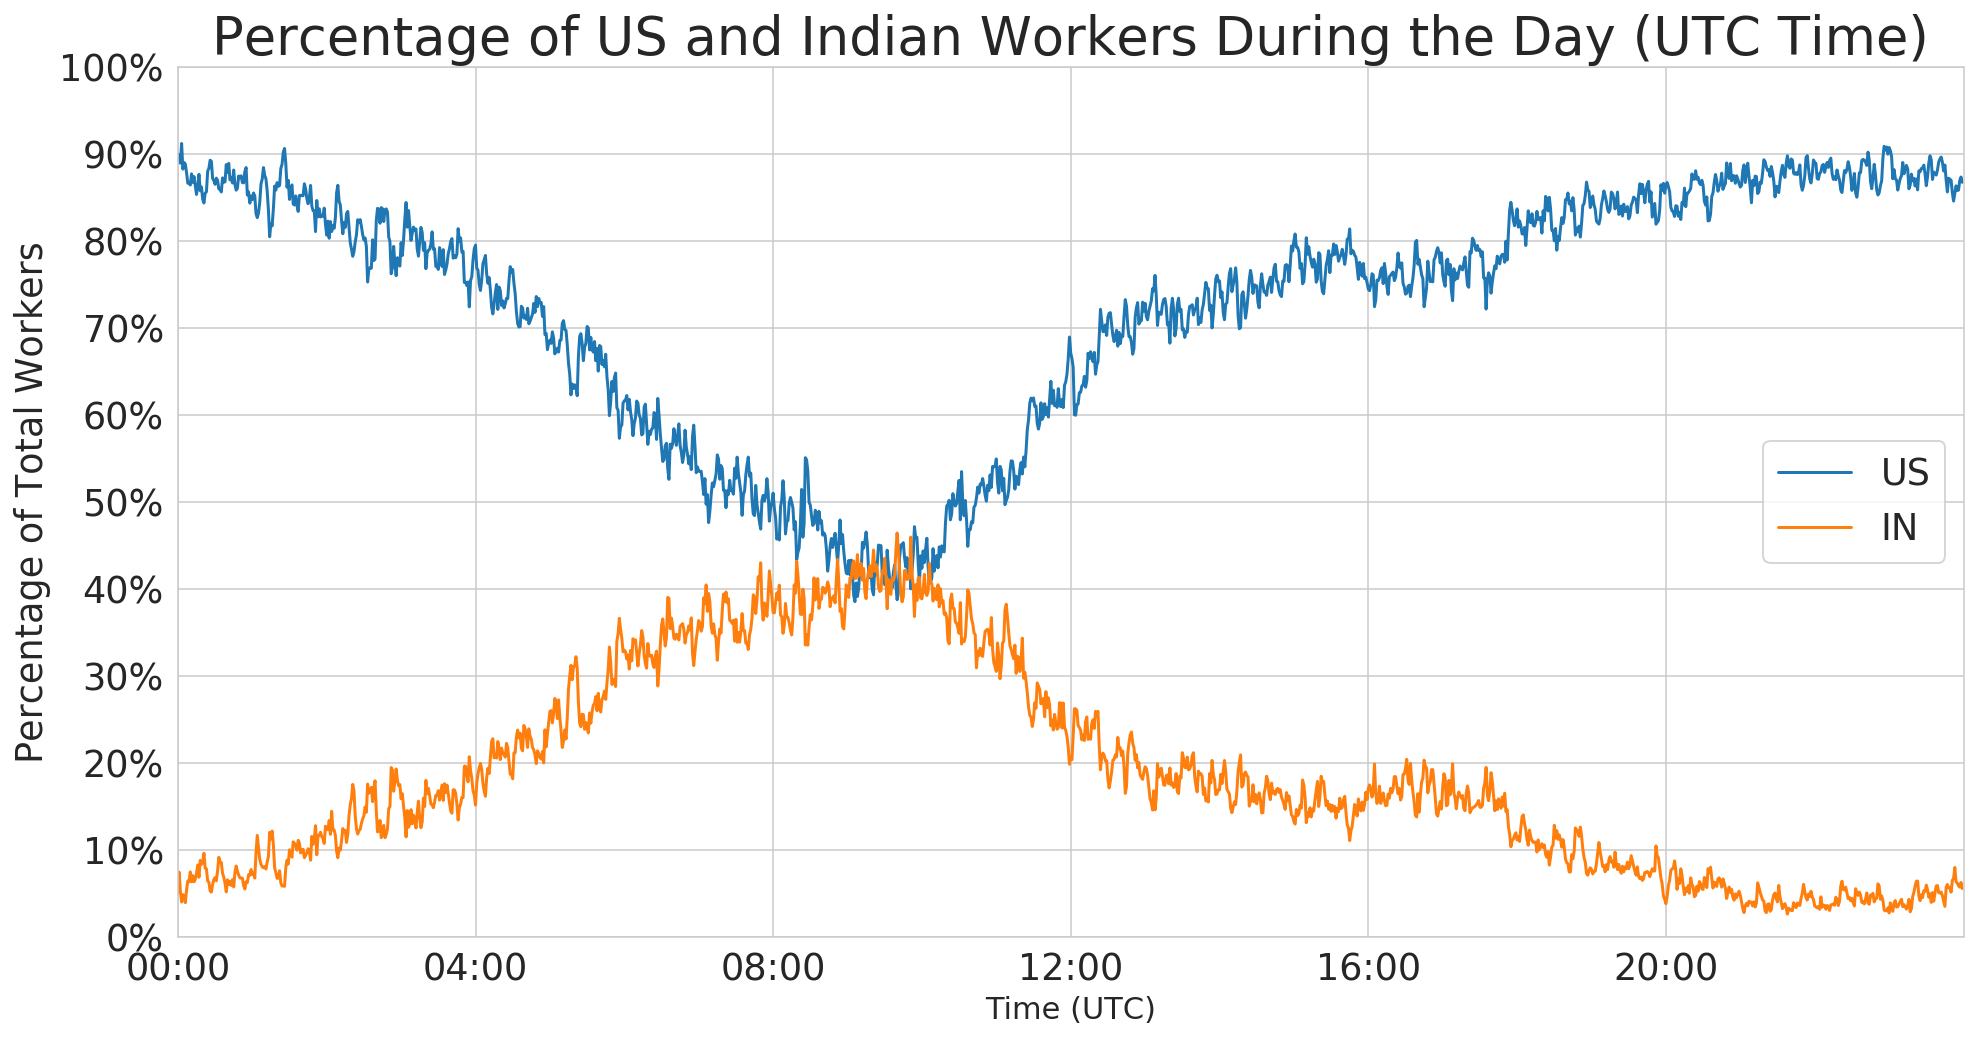

In [26]:
m = 100*country_table_time[['US','IN']].ewm(span=5).mean()

ax = m.plot( fontsize='small', xlim=[0,86400], ylim=[0,1])
ax.set_title("Percentage of US and Indian Workers During the Day (UTC Time)", fontsize='large')
ax.set_ylabel("Percentage of Total Workers", fontsize='small')
ax.set_xlabel("Time (UTC)", fontsize='x-small')
ax.xaxis.set_ticks(np.arange(0, 84400, 14400))
ax.yaxis.set_ticks(np.arange(0, 110, 10))
fmt = '%.0f%%' # Format you want the ticks, e.g. '40%'
yticks = mtick.FormatStrFormatter(fmt)
ax.yaxis.set_major_formatter(yticks)
    
ax.legend( fontsize='small')
fig = ax.get_figure()
fig.savefig('plots/country-usa-india-time-of-day.pdf', bbox_inches='tight')

In [27]:
# No significant periodicity
# from pandas.plotting import autocorrelation_plot
# data = country_table['US'].ewm(span=1).mean().diff()[1:]
# autocorrelation_plot(data)

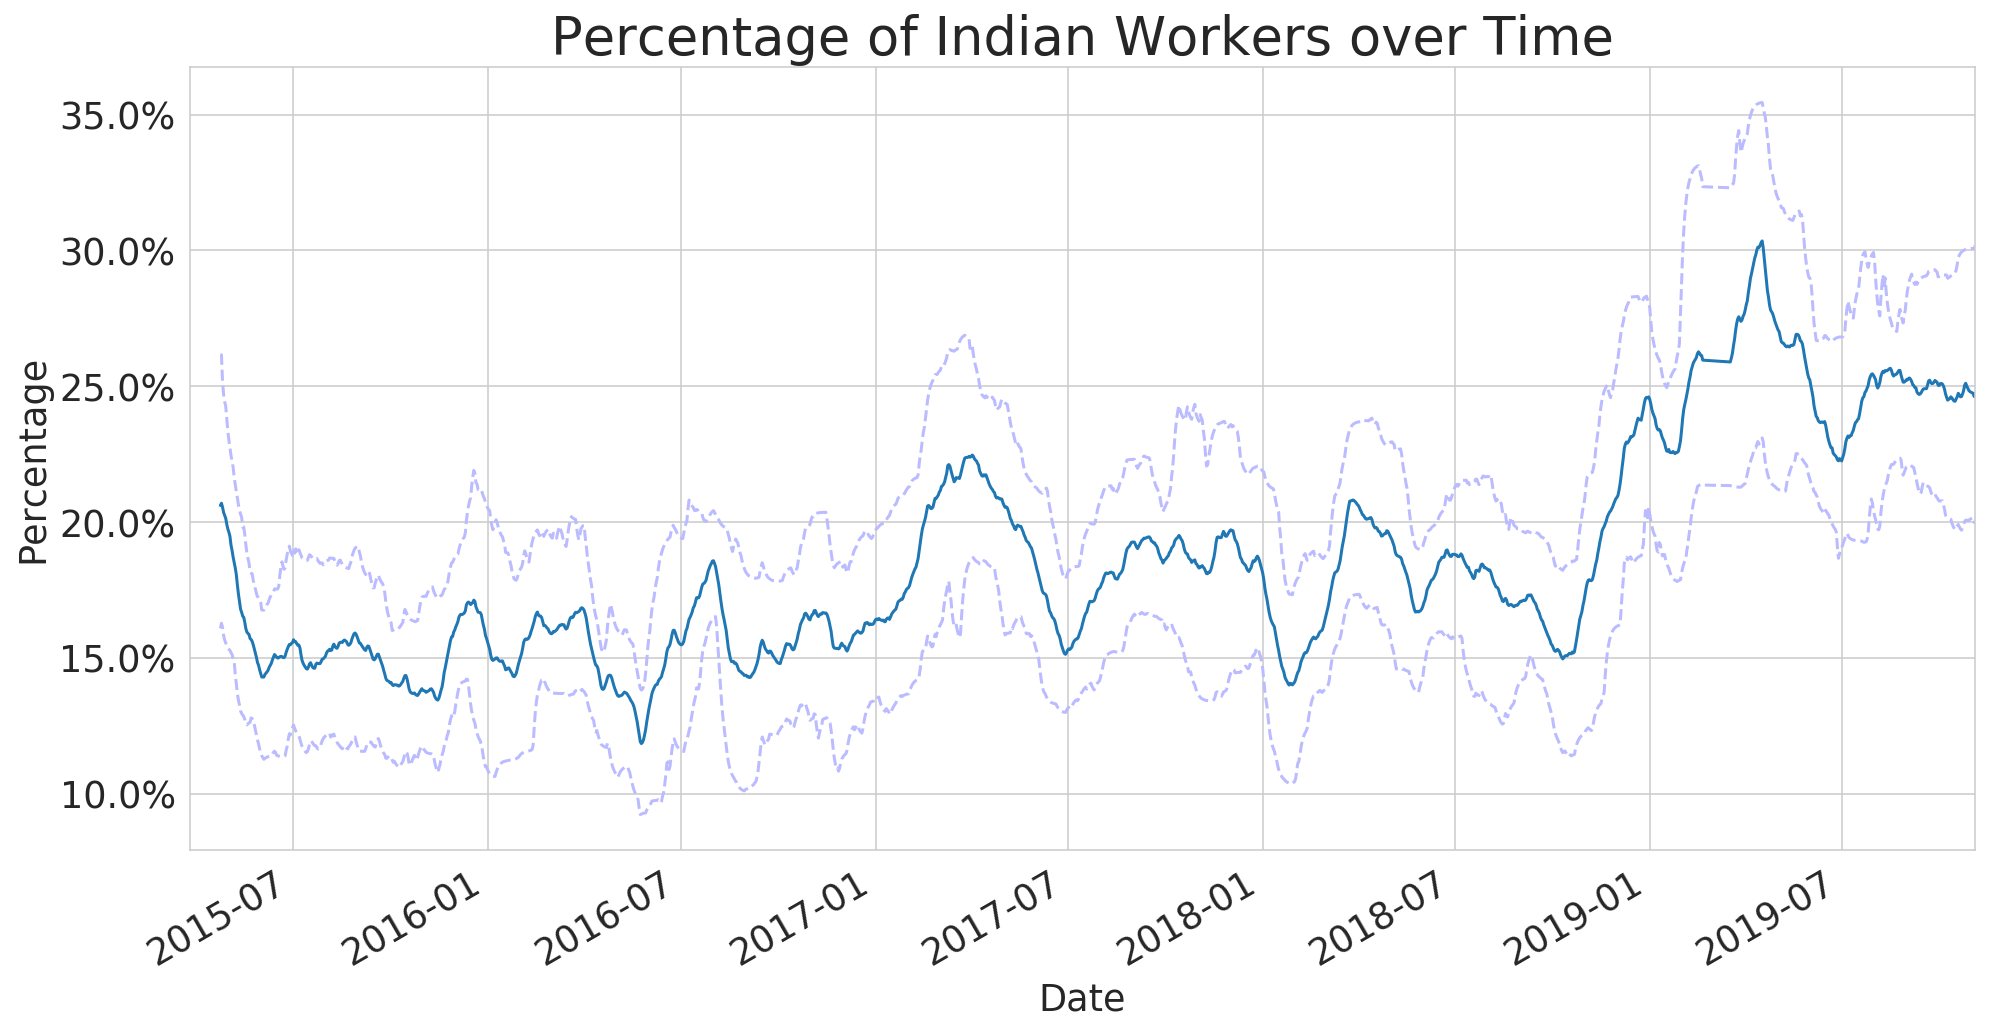

In [28]:
time_plot(100*country_table['IN'], 
          'Percentage of Indian Workers over Time', 
          'plots/country-india.pdf')

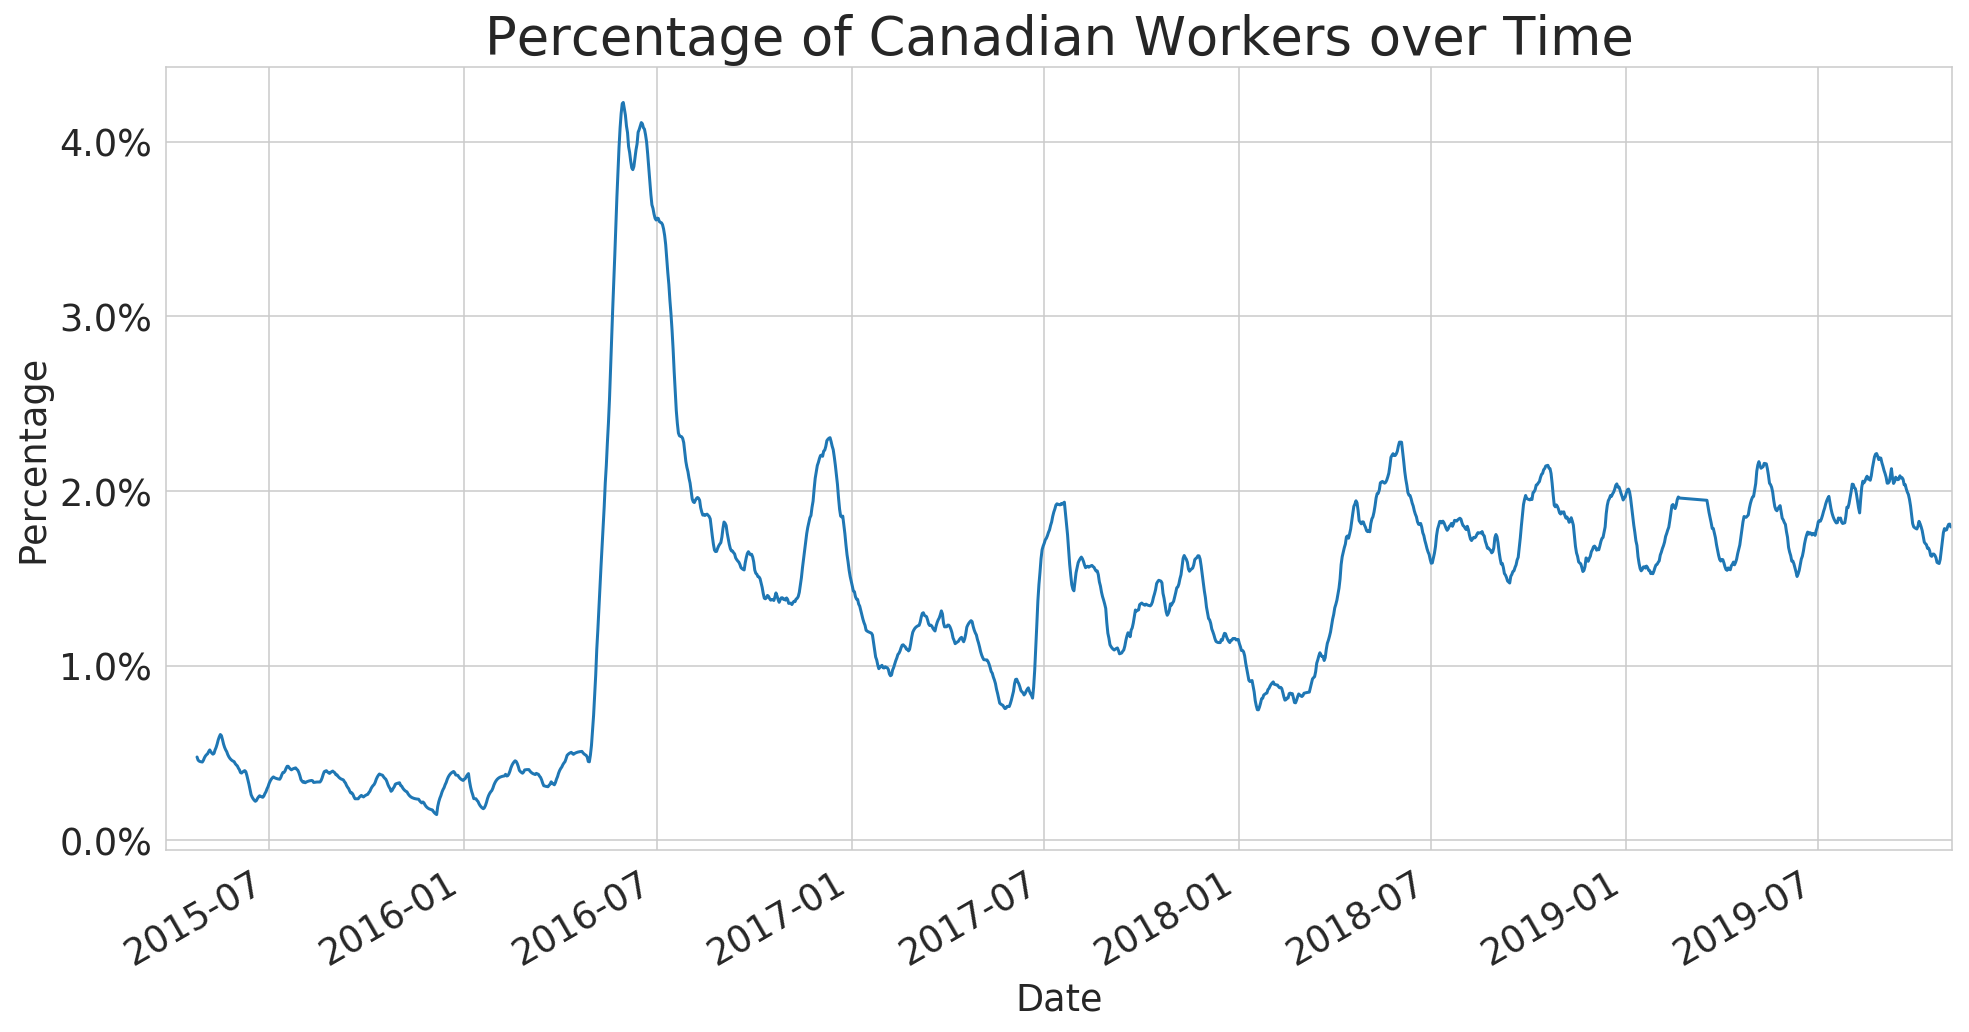

In [29]:
time_plot(data = 100*country_table['CA'], 
          title = 'Percentage of Canadian Workers over Time', 
          filename = 'plots/country-canada.pdf', 
          confidence=False)

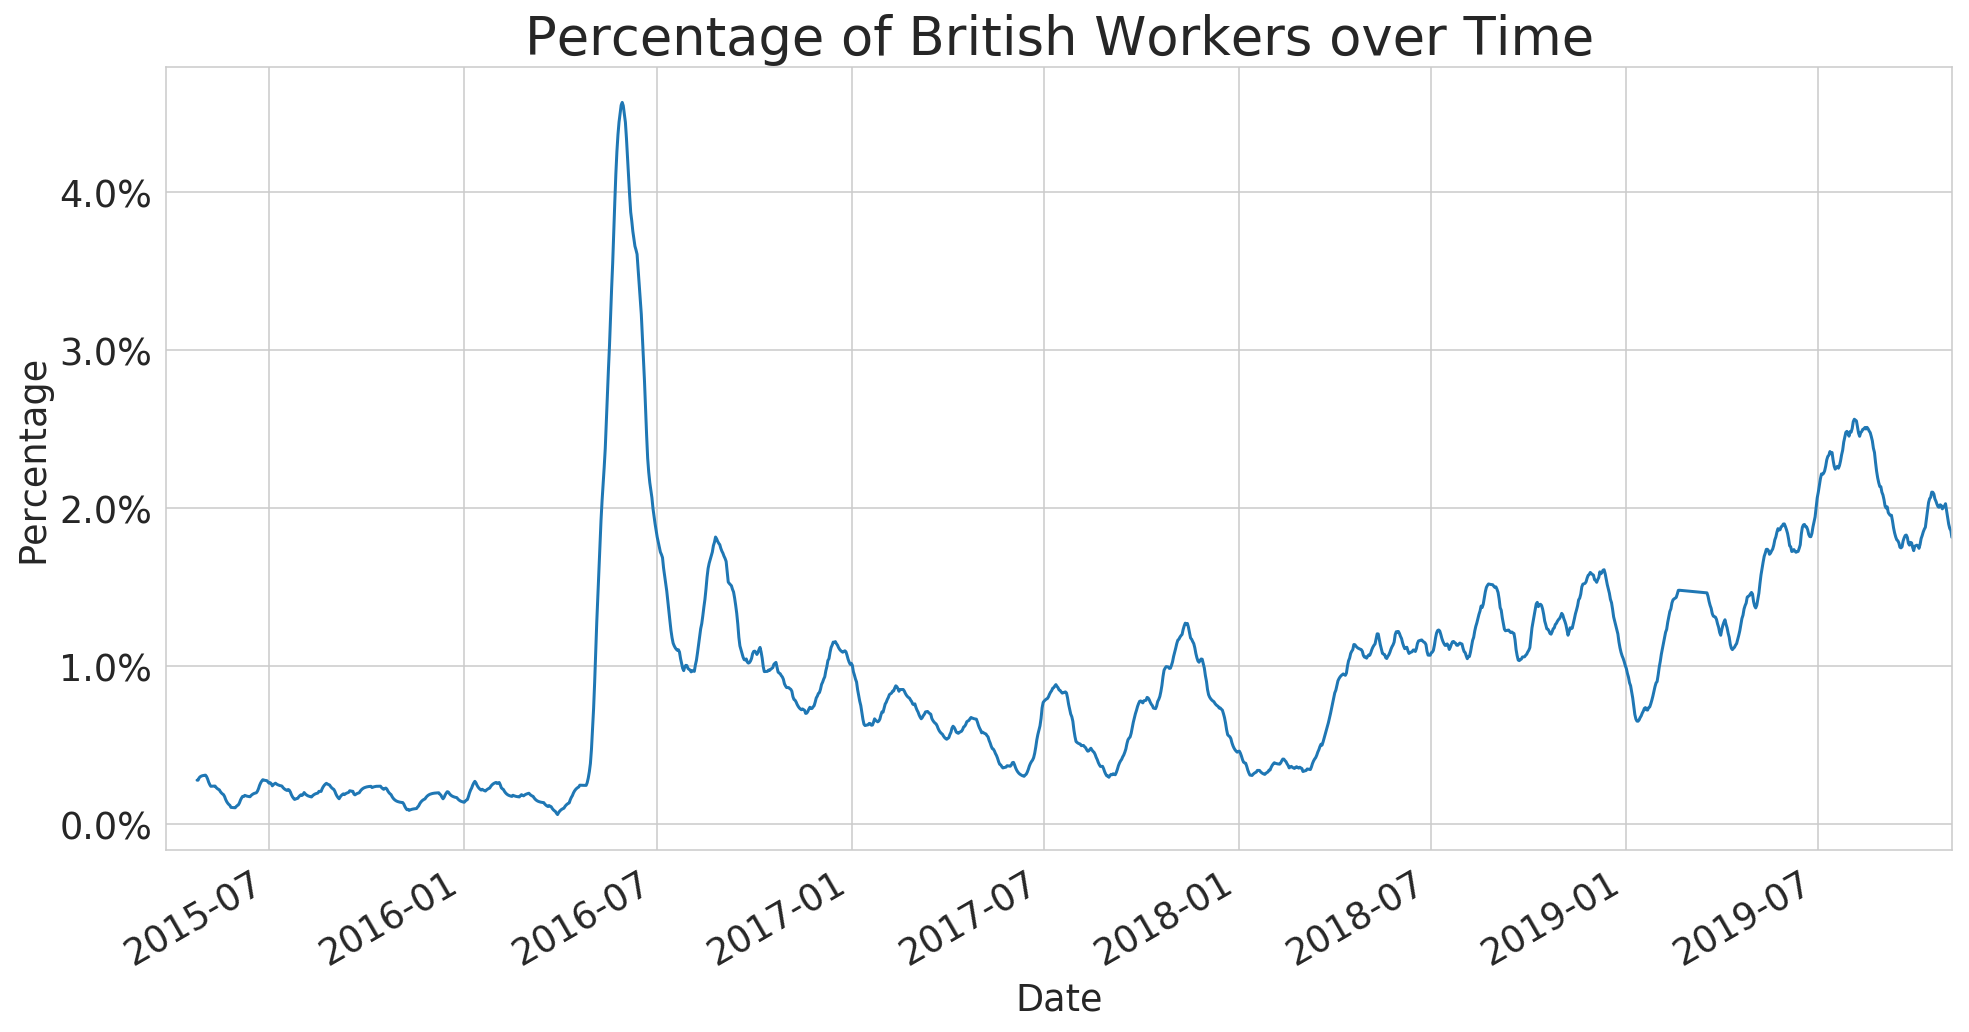

In [30]:
time_plot(data = 100*country_table['GB'], 
          title = 'Percentage of British Workers over Time', 
          filename = 'plots/country-uk.pdf', 
          confidence=False)

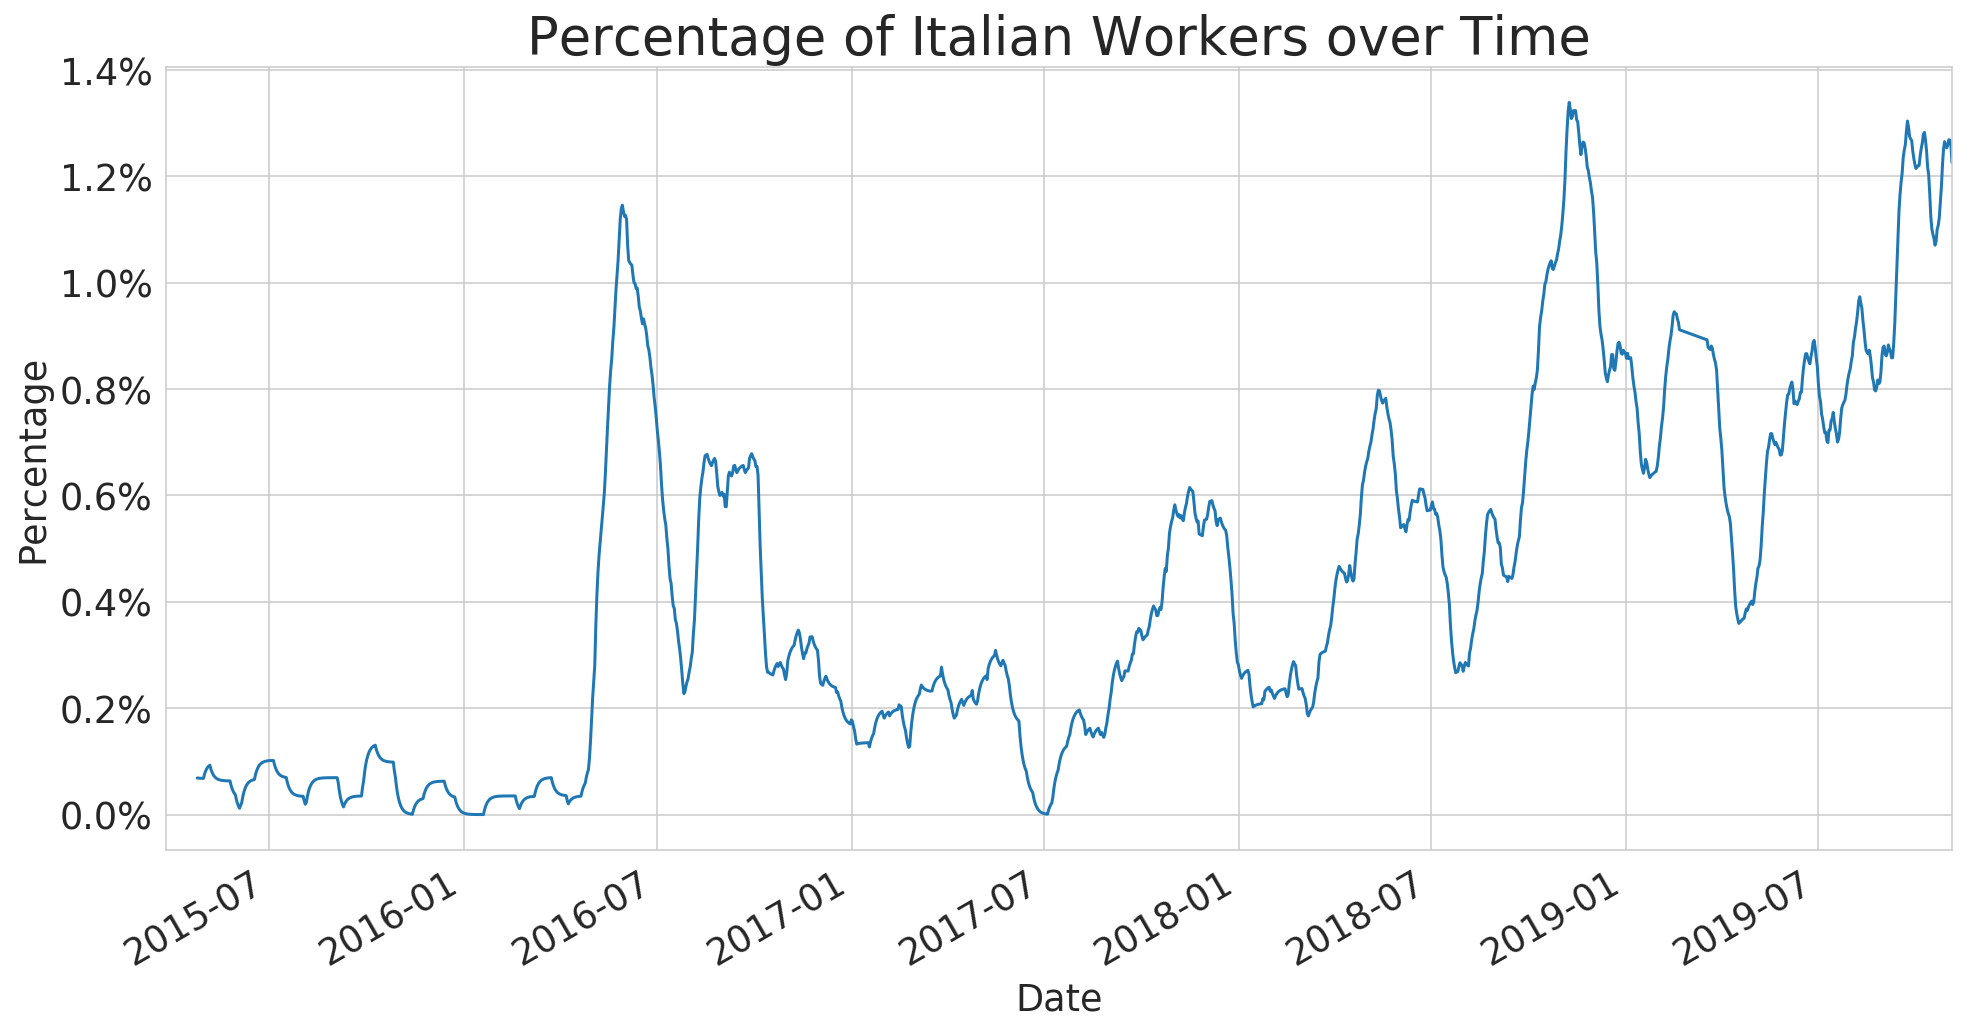

In [31]:
time_plot(100*country_table['IT'], 
          'Percentage of Italian Workers over Time', 
          'plots/country-italy.pdf',
          confidence=False)

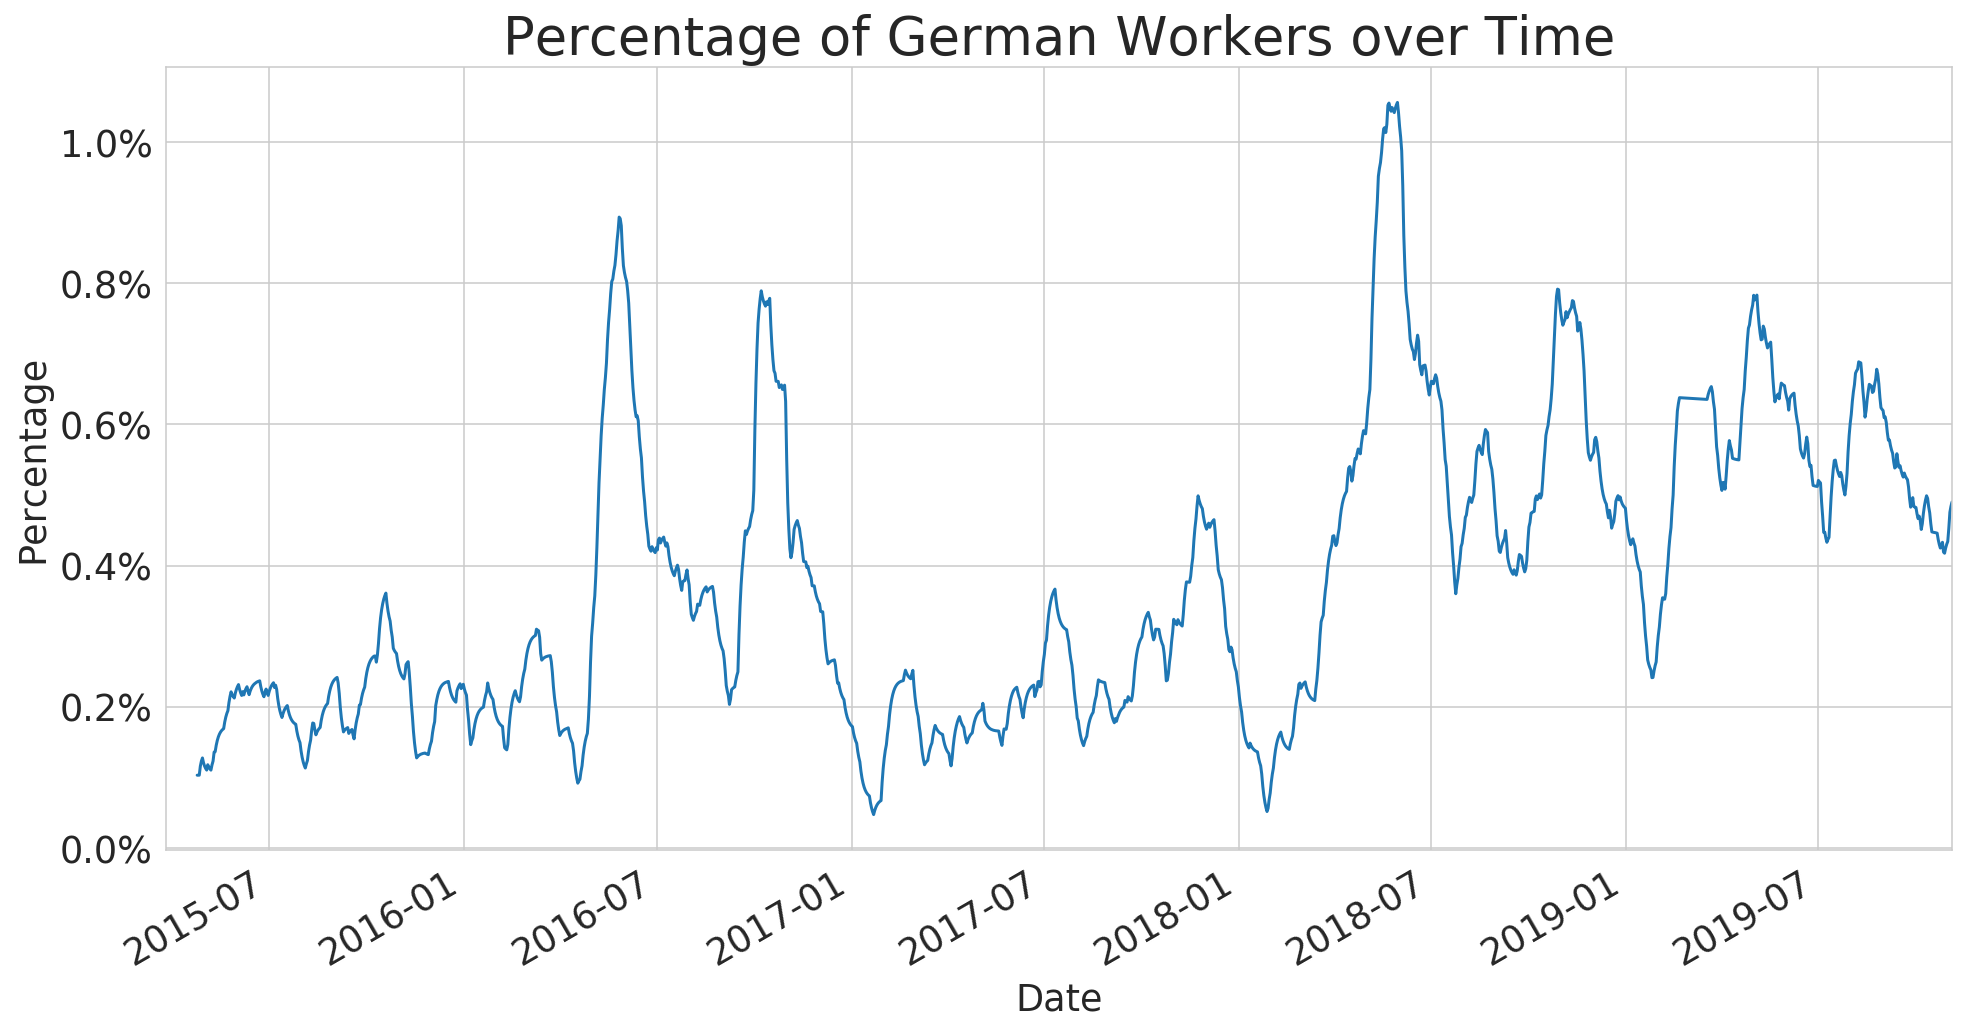

In [32]:
time_plot(100*country_table['DE'], 
          'Percentage of German Workers over Time', 
          'plots/country-germany.pdf',
          confidence=False)

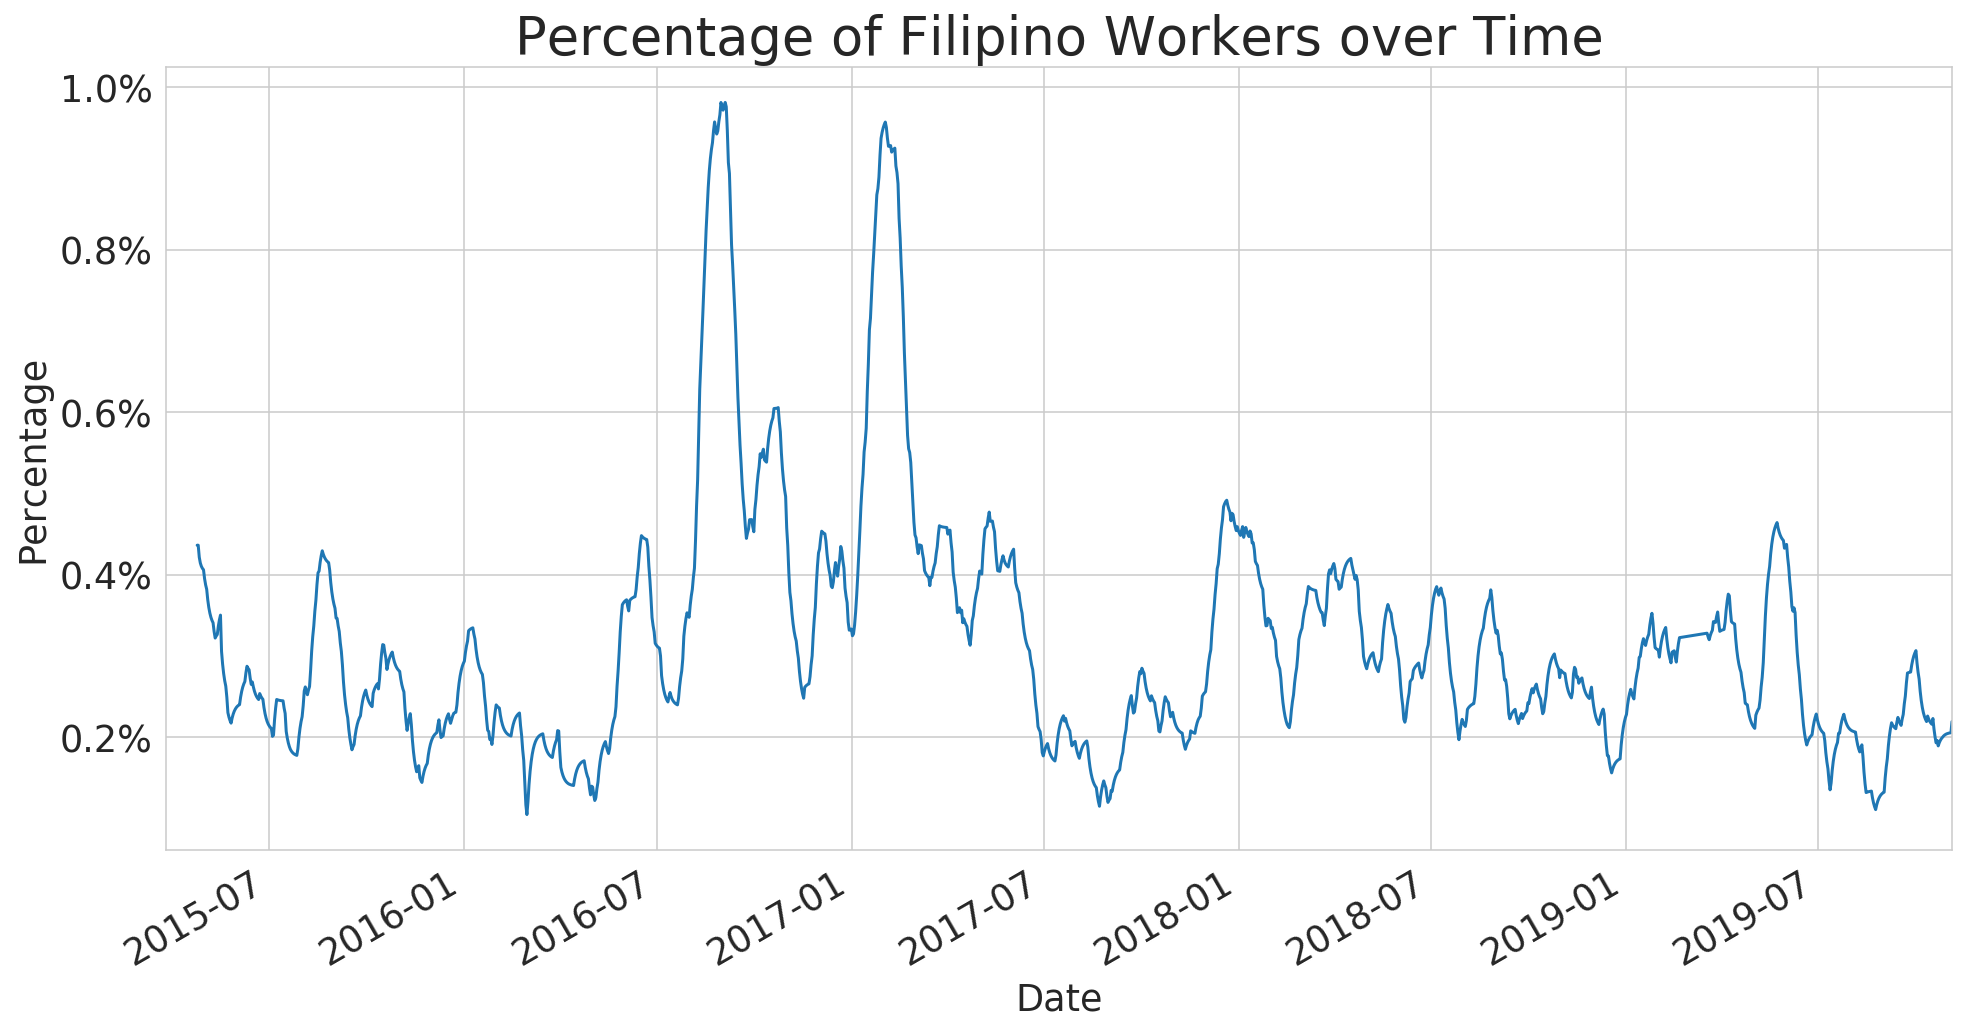

In [33]:
time_plot(100*country_table['PH'], 
          'Percentage of Filipino Workers over Time', 
          'plots/country-philipines.pdf',
          confidence=False)

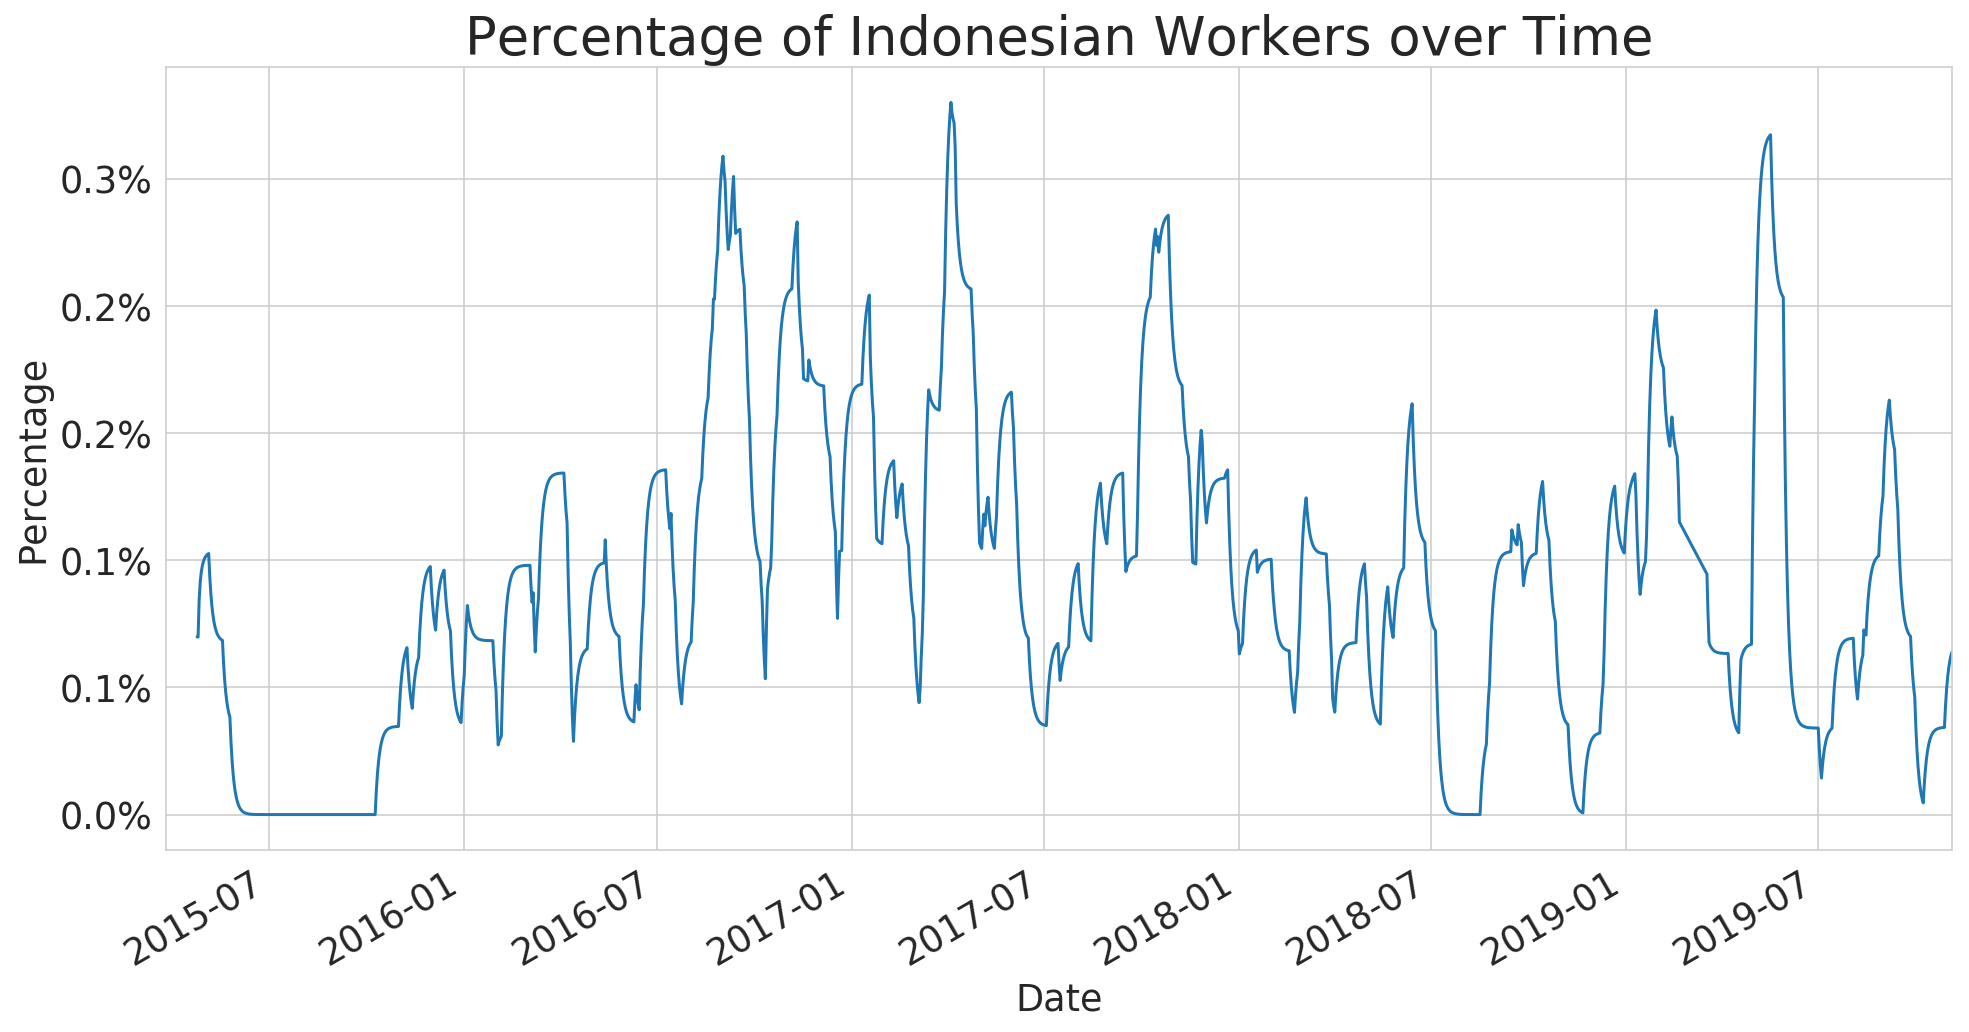

In [34]:
time_plot(100*country_table['ID'], 
          'Percentage of Indonesian Workers over Time', 
          'plots/country-indonesia.pdf',
          confidence=False)

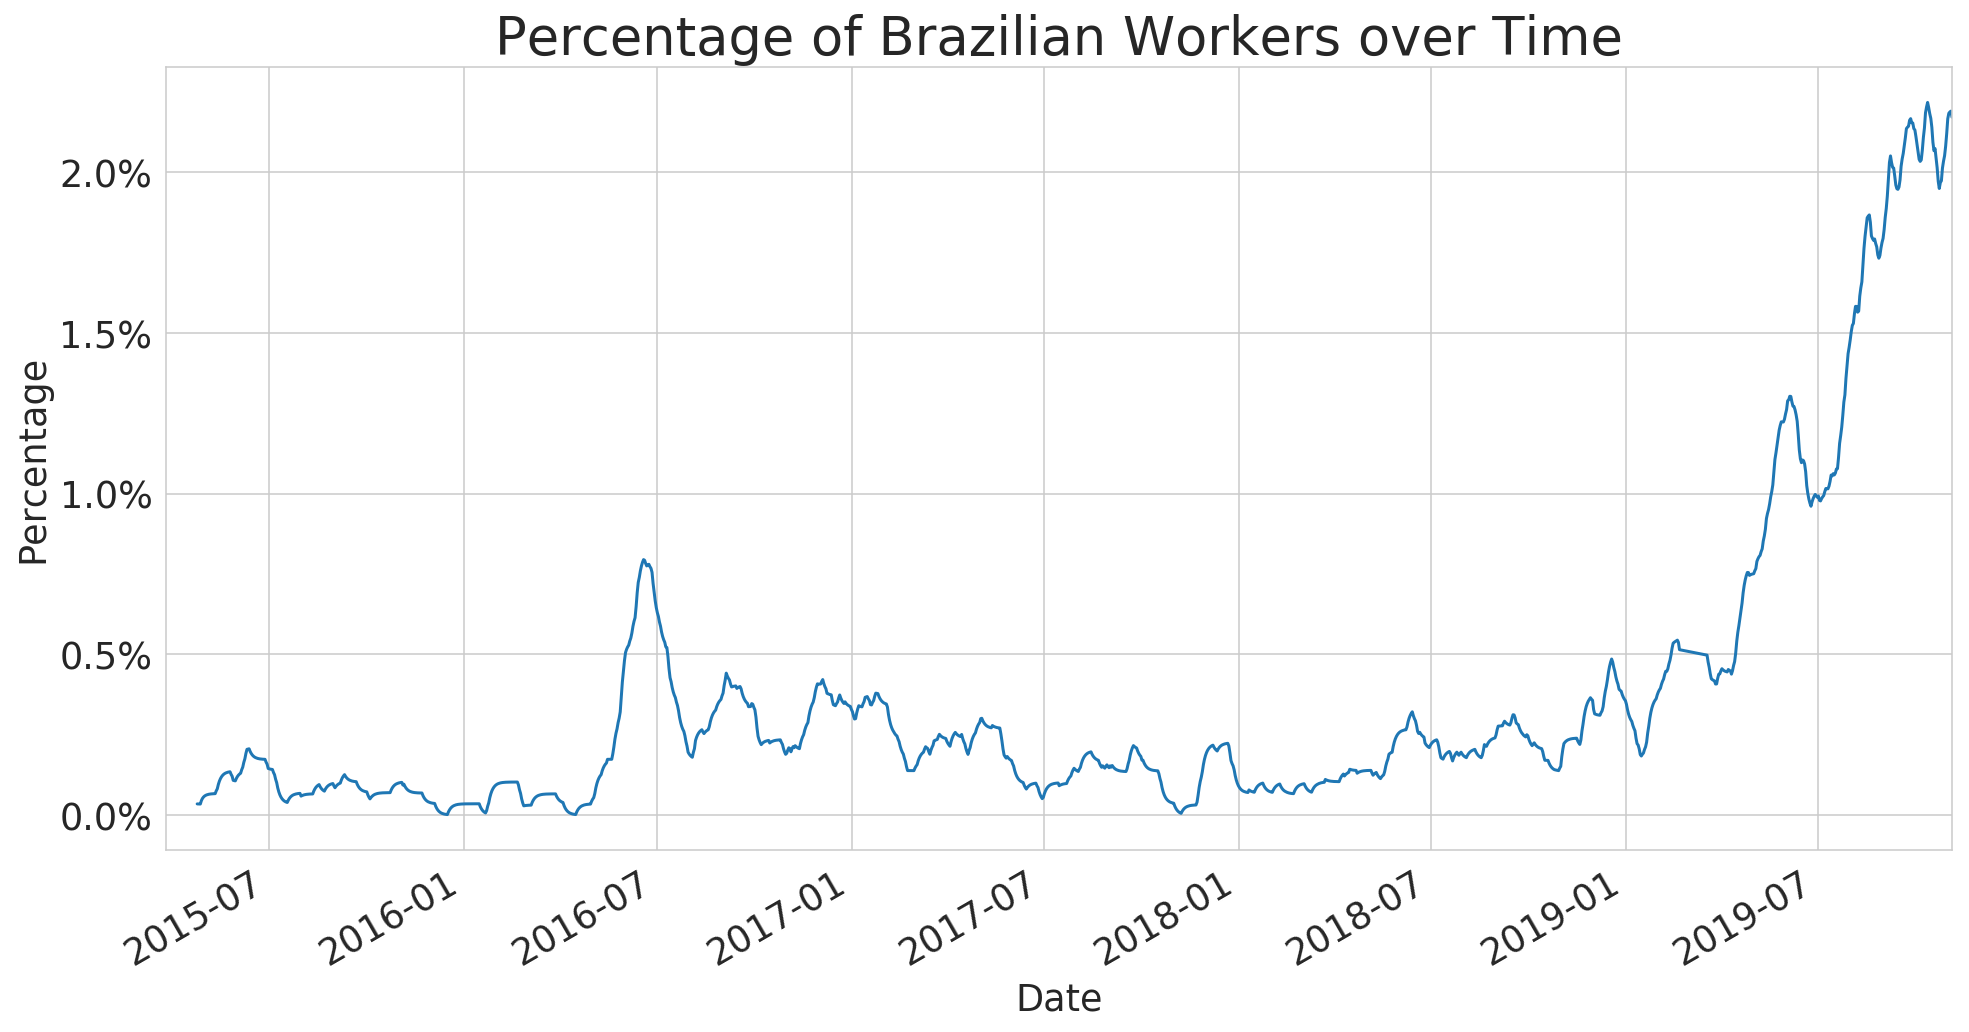

In [35]:
time_plot(100*country_table['BR'], 
          'Percentage of Brazilian Workers over Time', 
          'plots/country-brazil.pdf',
          confidence=False)

## Gender

In [36]:
gender_table = pd.crosstab(index=df.date, columns=df.gender, 
                            values='worker_id', aggfunc=np.count_nonzero, normalize='index')

In [37]:
gender_table.mean()

gender
female    0.487113
male      0.512887
dtype: float64

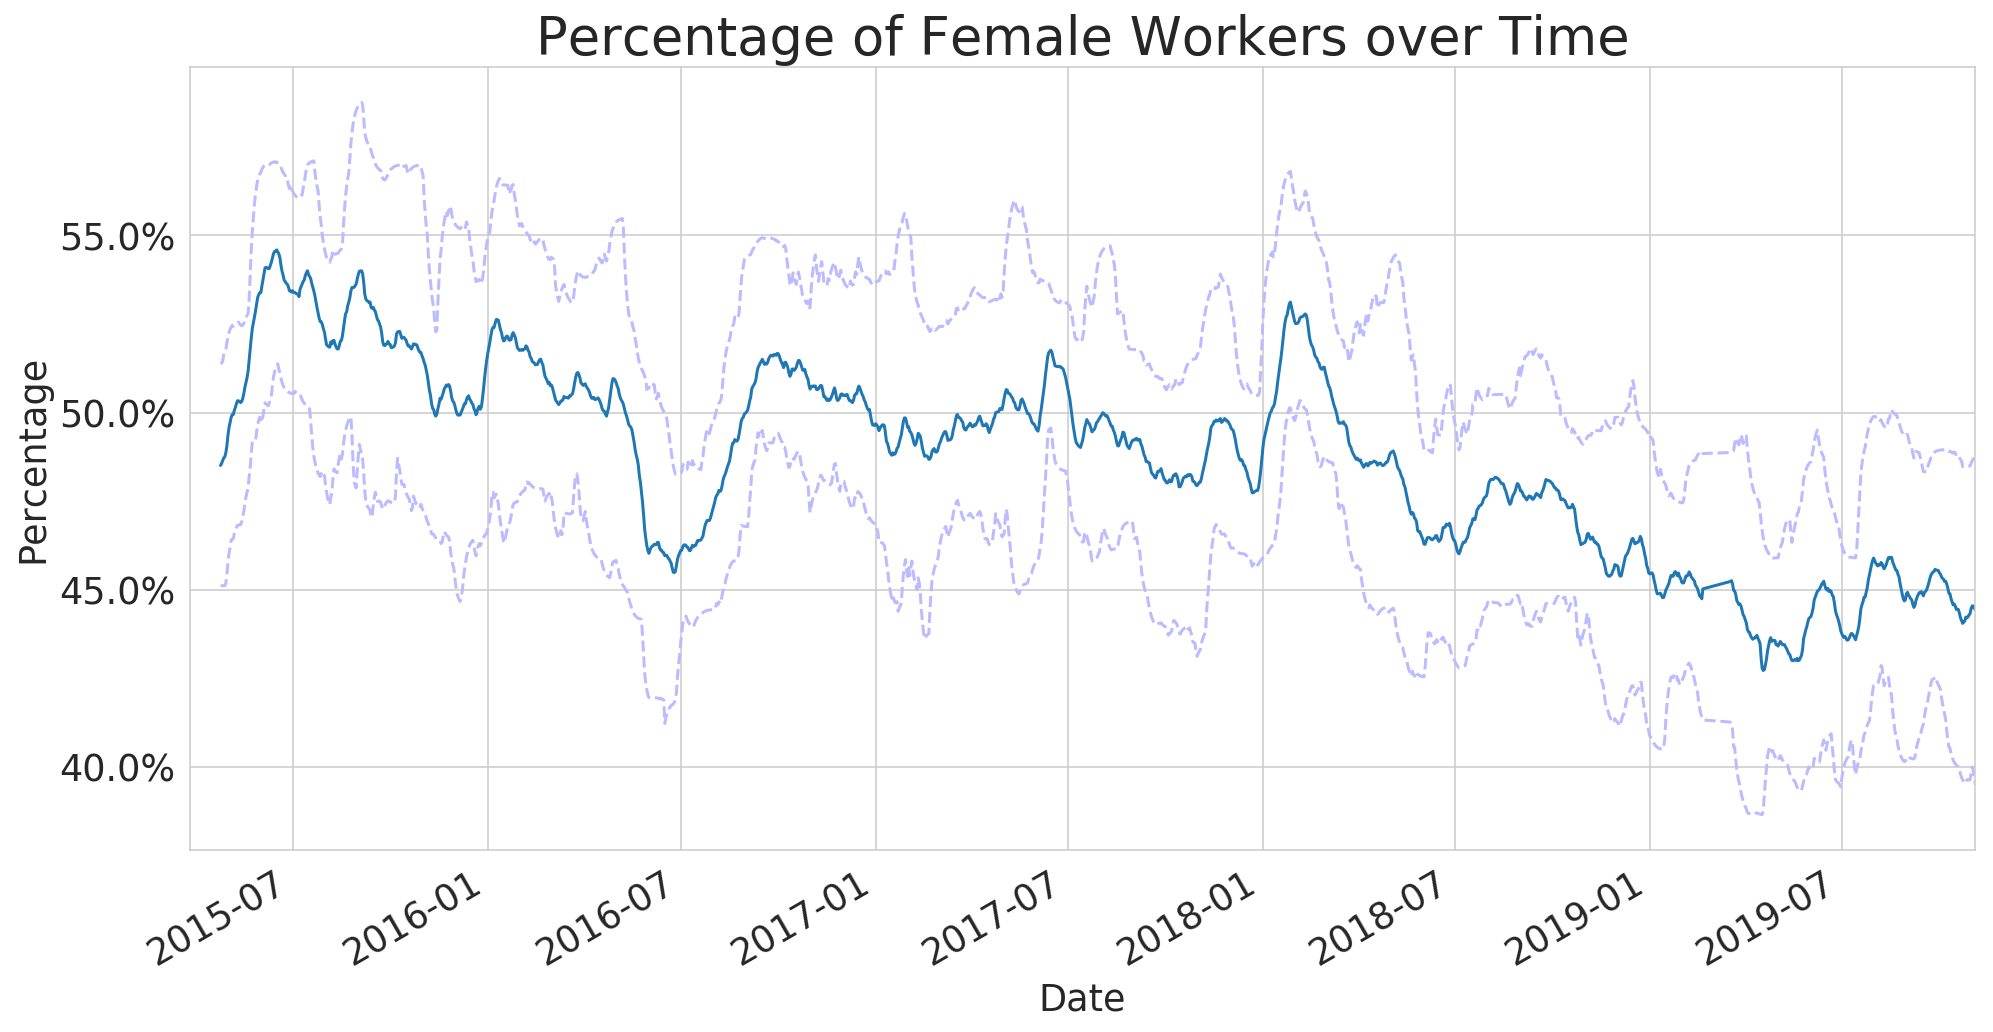

In [38]:
time_plot(data = 100*gender_table['female'], 
          title = 'Percentage of Female Workers over Time', 
          filename = 'plots/gender-female.pdf', 
          confidence=True)

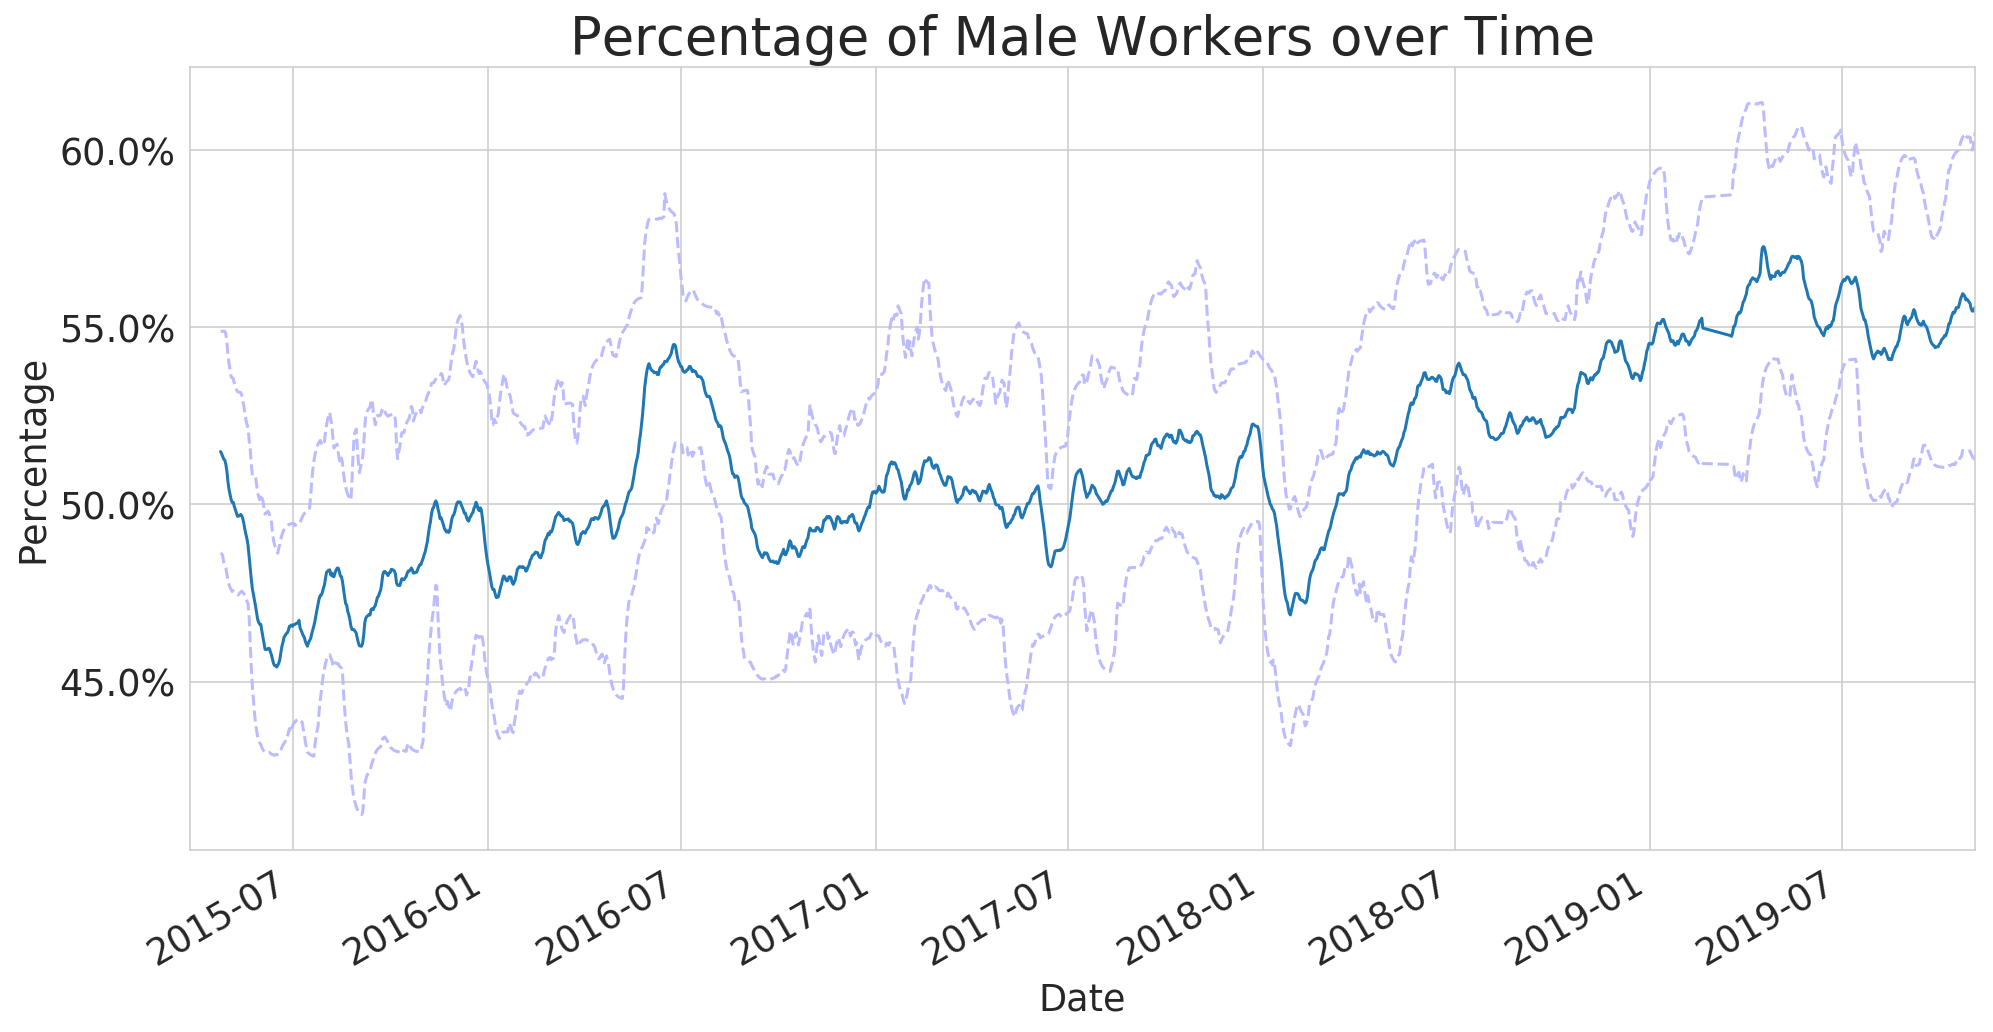

In [39]:
time_plot(data = 100*gender_table['male'], 
          title = 'Percentage of Male Workers over Time', 
          filename = 'plots/gender-male.pdf', 
          confidence=True)

### Gender by Country

In [40]:
gender_by_country = pd.pivot_table(data=df,
                             values='worker_id', 
                             aggfunc=np.count_nonzero,
                             index=df.location_country,
                             columns=df.gender)

In [41]:

# Keep only US and India
gender_by_country = gender_by_country[gender_by_country.index.isin(['US', 'IN', 'CA', 'GB', 'PH', 'DE', 'IT', 'FR'])]
# Normalize and keep percentages
gender_by_country_perc = gender_by_country.apply(lambda x: 100*x / float(x.sum()), axis=1).round(2)
gender_by_country_perc = gender_by_country_perc.reindex(['US', 'IN', 'CA', 'GB', 'IT', 'PH', 'DE', 'FR' ])

In [42]:
gender_by_country.sum()

gender
female    76565.0
male      77501.0
dtype: float64

In [43]:
gender_by_country.sum()/gender_by_country.sum().sum()

gender
female    0.496962
male      0.503038
dtype: float64

In [44]:
gender_by_country

gender             female     male
location_country                  
CA                  964.0   1265.0
DE                  177.0    432.0
FR                  115.0    321.0
GB                  561.0    997.0
IN                10881.0  19287.0
IT                  249.0    448.0
PH                  210.0    304.0
US                63408.0  54447.0

In [45]:
gender_by_country_perc_df = gender_by_country_perc[['female','male']]

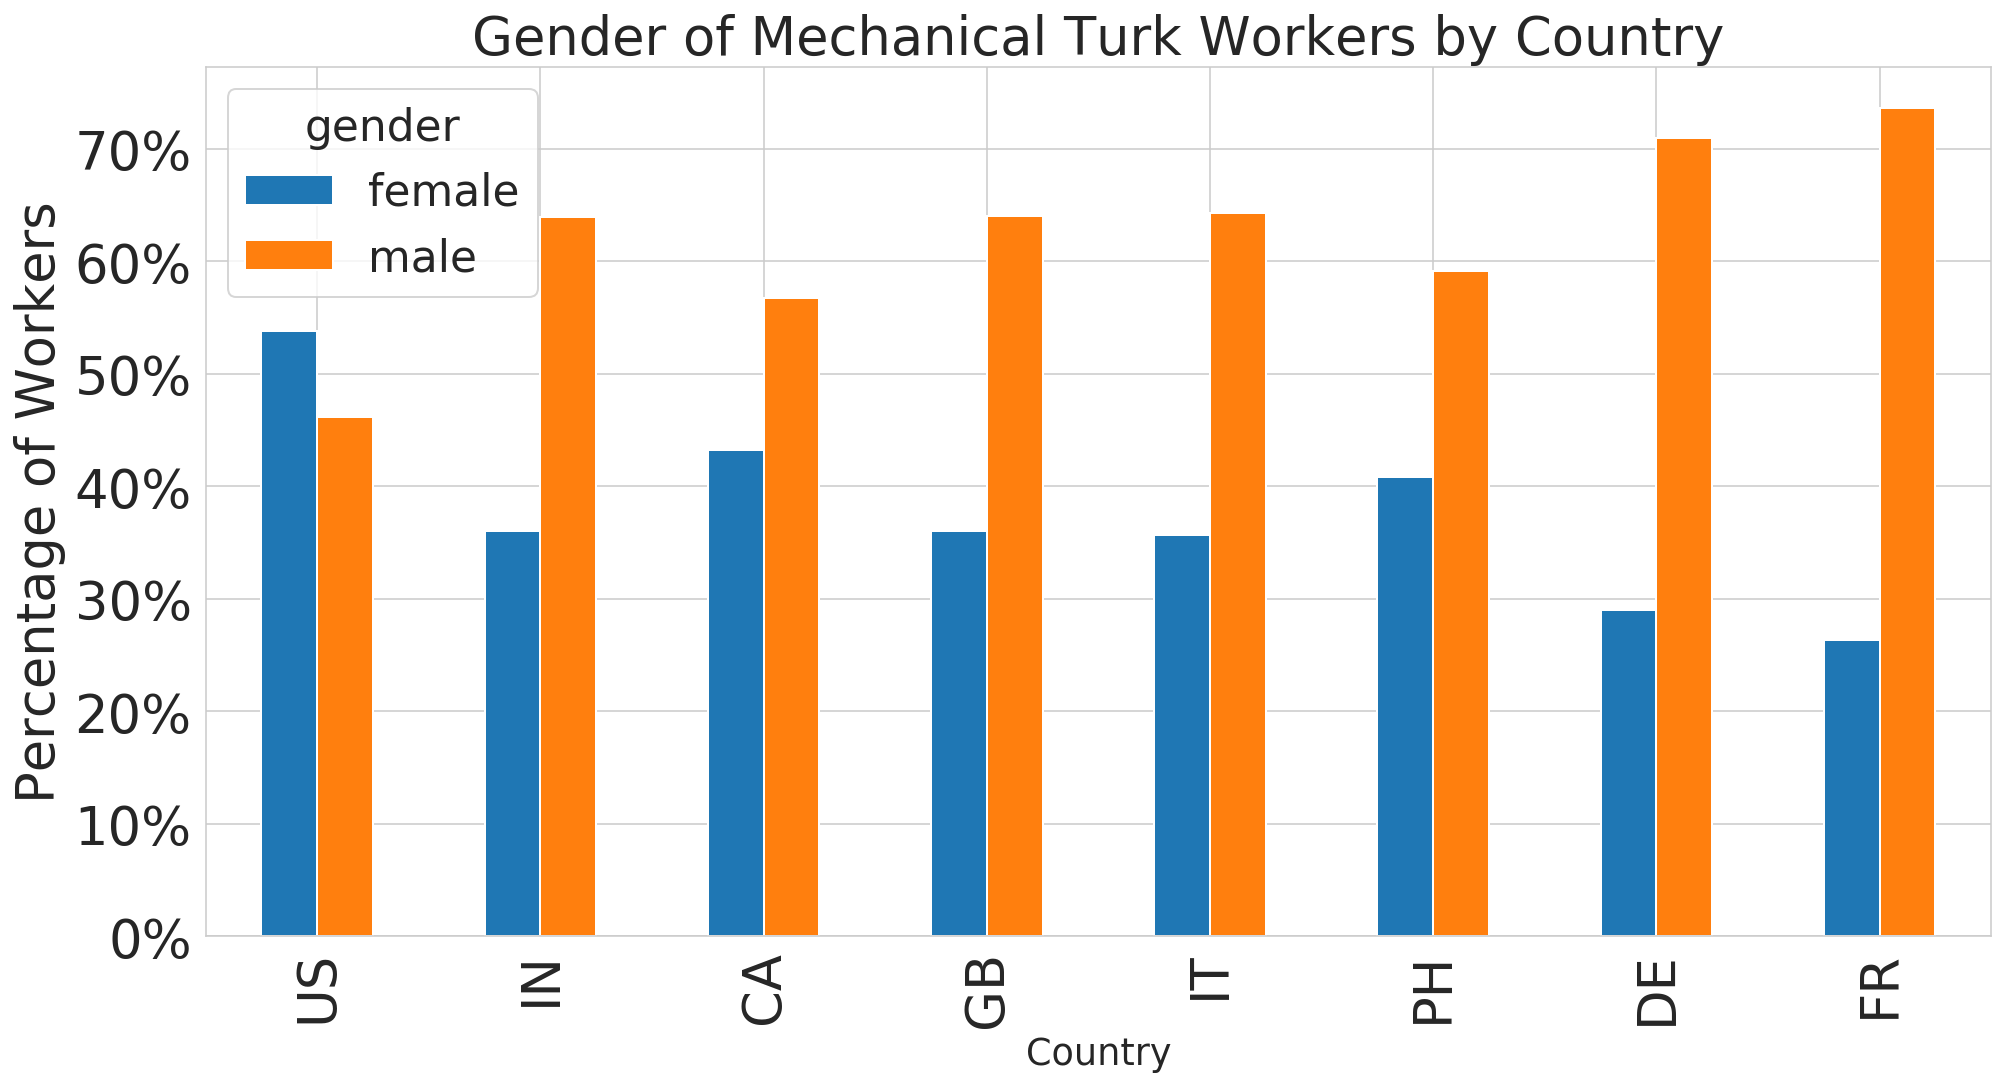

In [46]:
ax = gender_by_country_perc_df.plot.bar(fontsize='large')
ax.set_title("Gender of Mechanical Turk Workers by Country", fontsize='large')
ax.set_xlabel("Country", fontsize='small')
ax.set_ylabel("Percentage of Workers", fontsize='large')

fmt = '%.0f%%' # Format you want the ticks, e.g. '40%'
yticks = mtick.FormatStrFormatter(fmt)
ax.yaxis.set_major_formatter(yticks)

fig = ax.get_figure()
fig.savefig('plots/gender.pdf', bbox_inches='tight')

### Gender by Country over Time

In [47]:
gender_table_us = pd.crosstab(index=df[df.location_country=='US'].date, columns=df[df.location_country=='US'].gender, 
                            values='worker_id', aggfunc=np.count_nonzero, normalize='index')

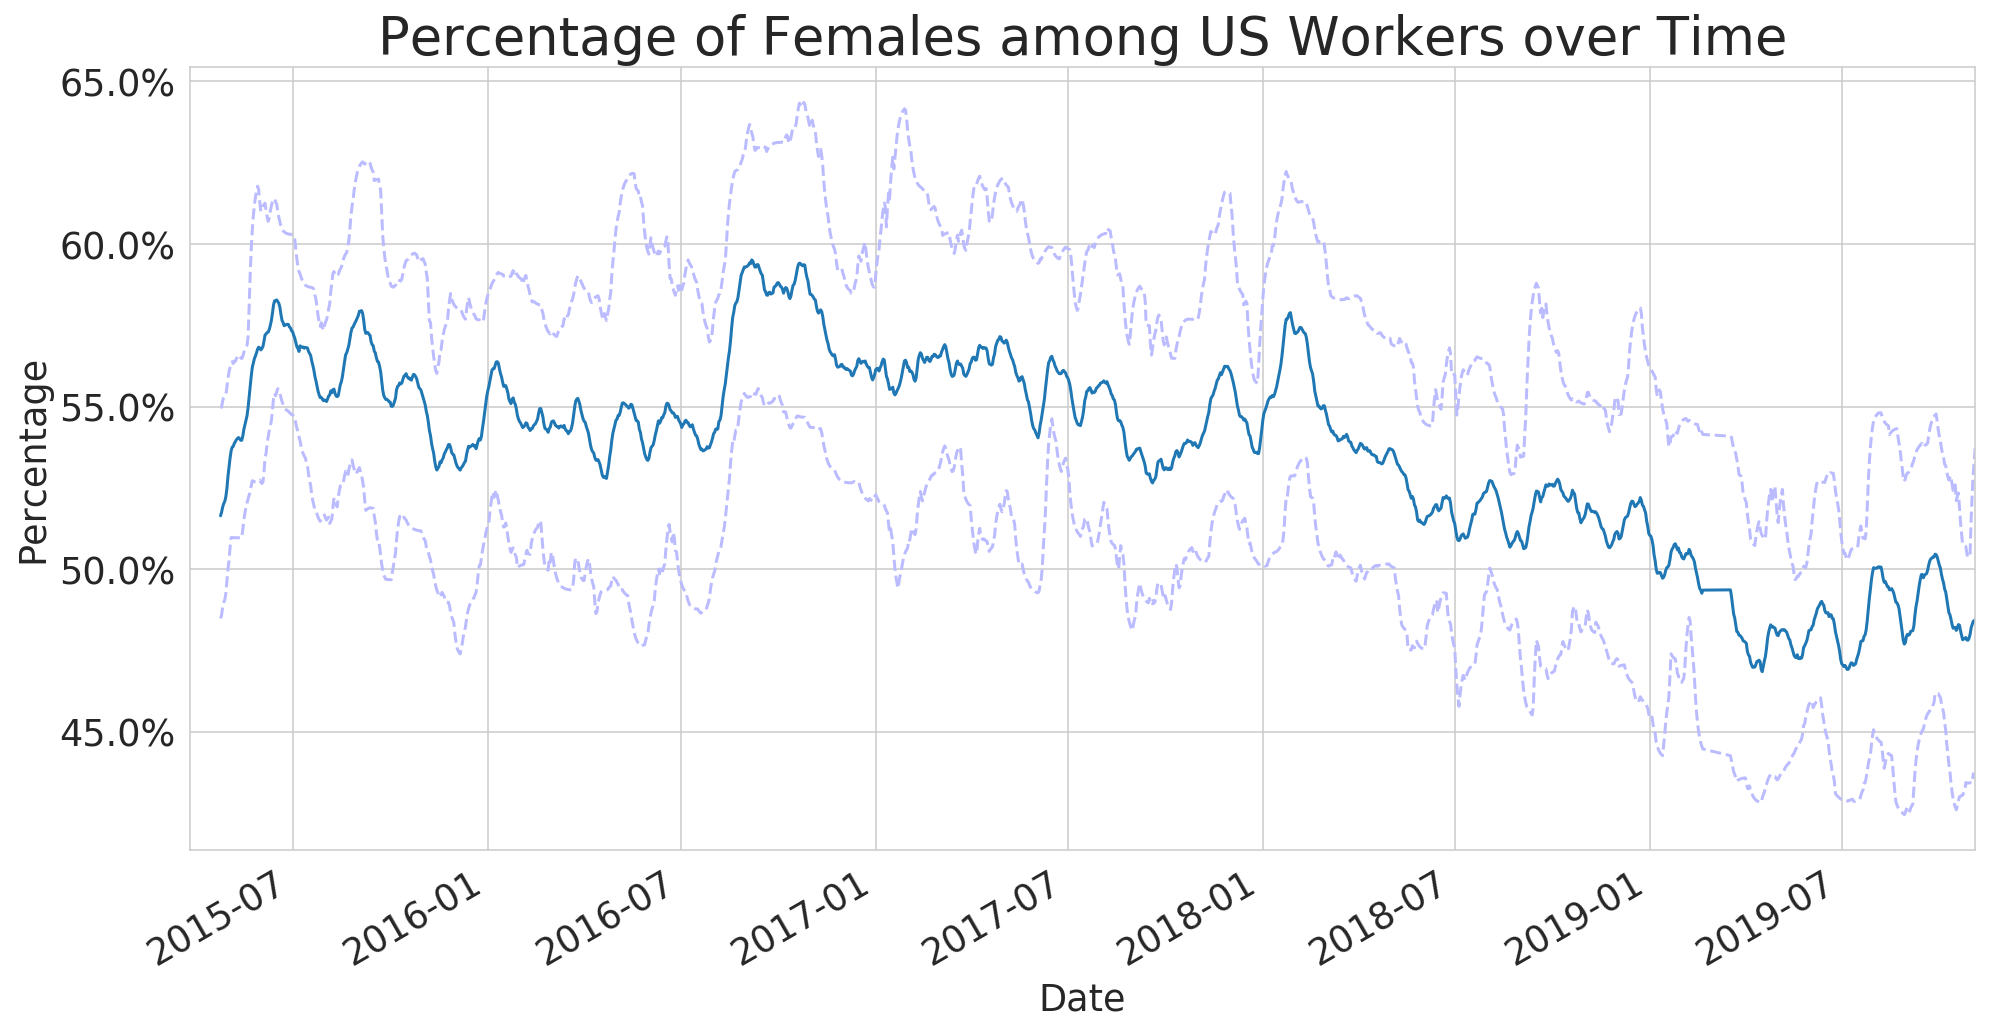

In [48]:
time_plot(data = 100*gender_table_us['female'], 
          title = 'Percentage of Females among US Workers over Time', 
          filename = 'plots/gender-female-usa.pdf', 
          confidence=True)

In [49]:
gender_table_in = pd.crosstab(index=df[df.location_country=='IN'].date, columns=df[df.location_country=='IN'].gender, 
                            values='worker_id', aggfunc=np.count_nonzero, normalize='index')

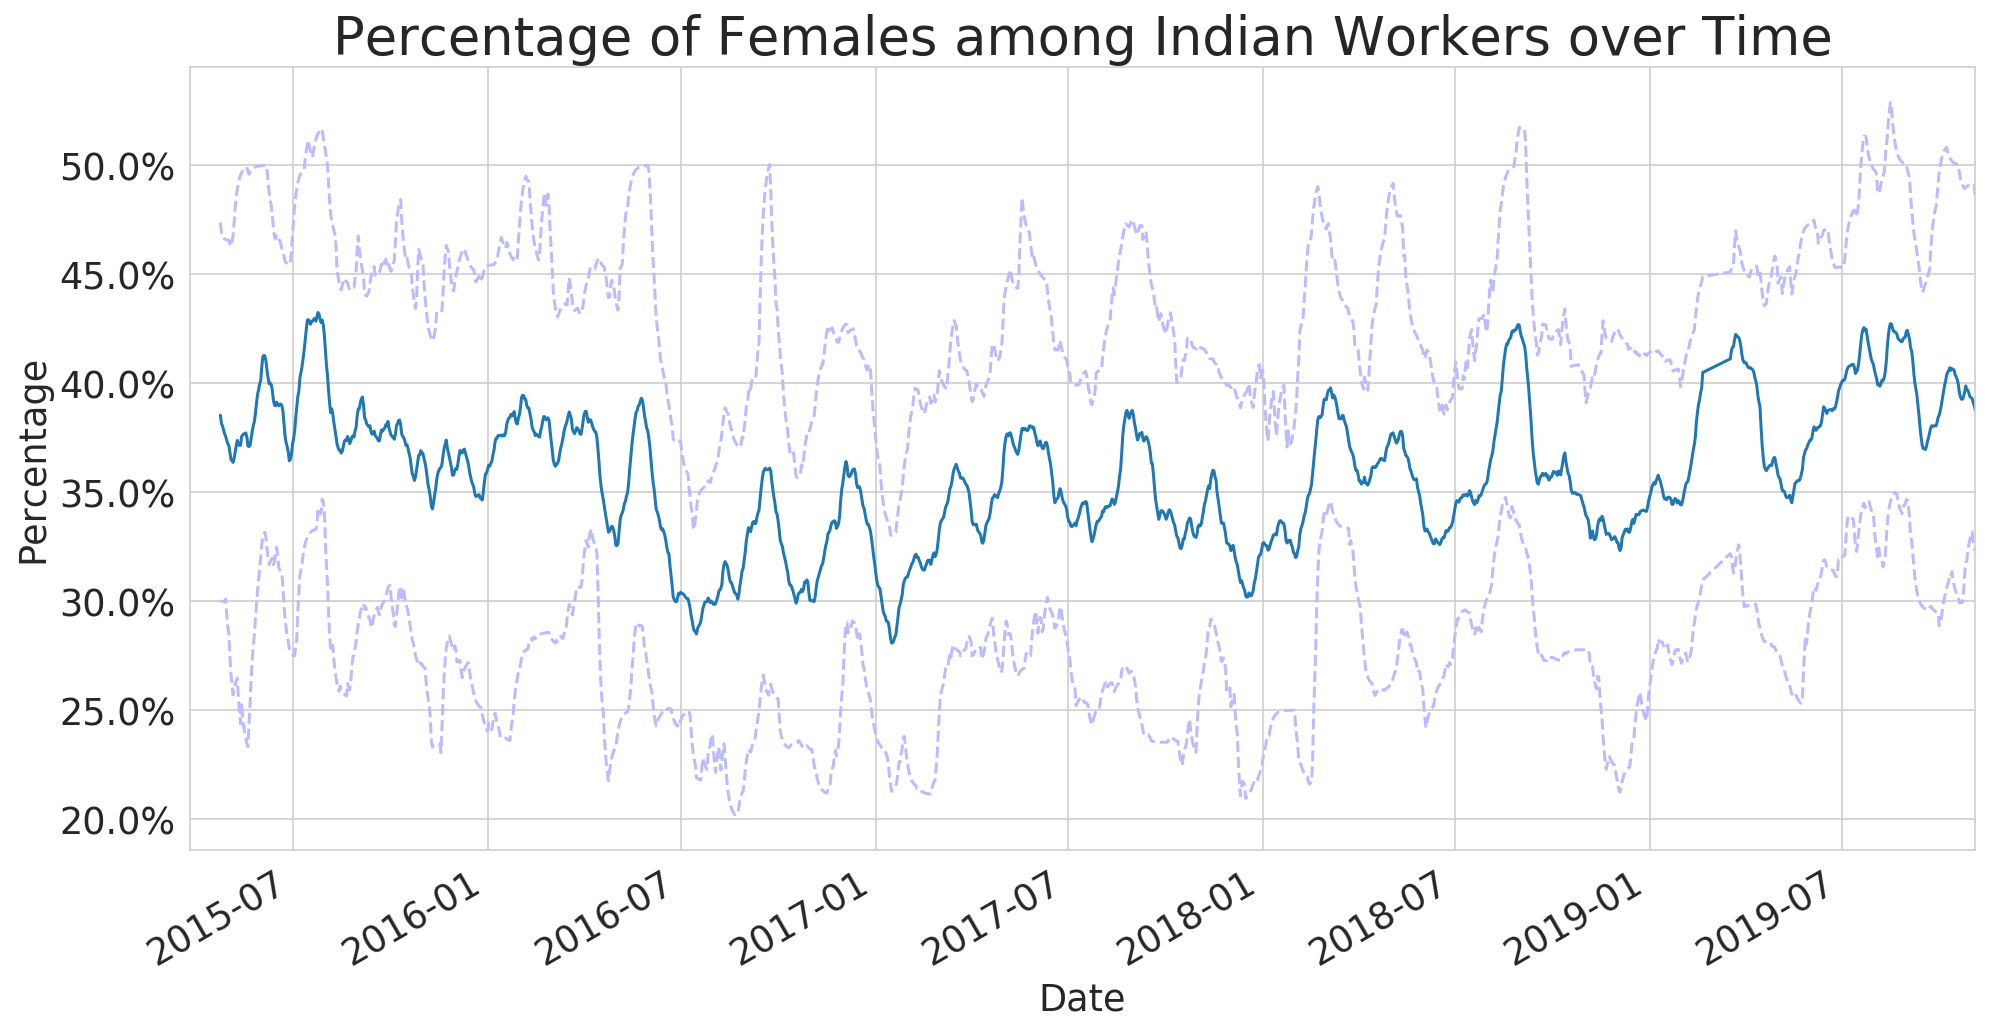

In [50]:
time_plot(data = 100*gender_table_in['female'], 
          title = 'Percentage of Females among Indian Workers over Time', 
          filename = 'plots/gender-female-india.pdf', 
          confidence=True)

### Year of Birth

In [51]:
yob_table = pd.crosstab(index=df.date, columns=df.year_of_birth, 
                            values='worker_id', aggfunc=np.count_nonzero, normalize='index')

In [52]:
# yob_table.head(5)

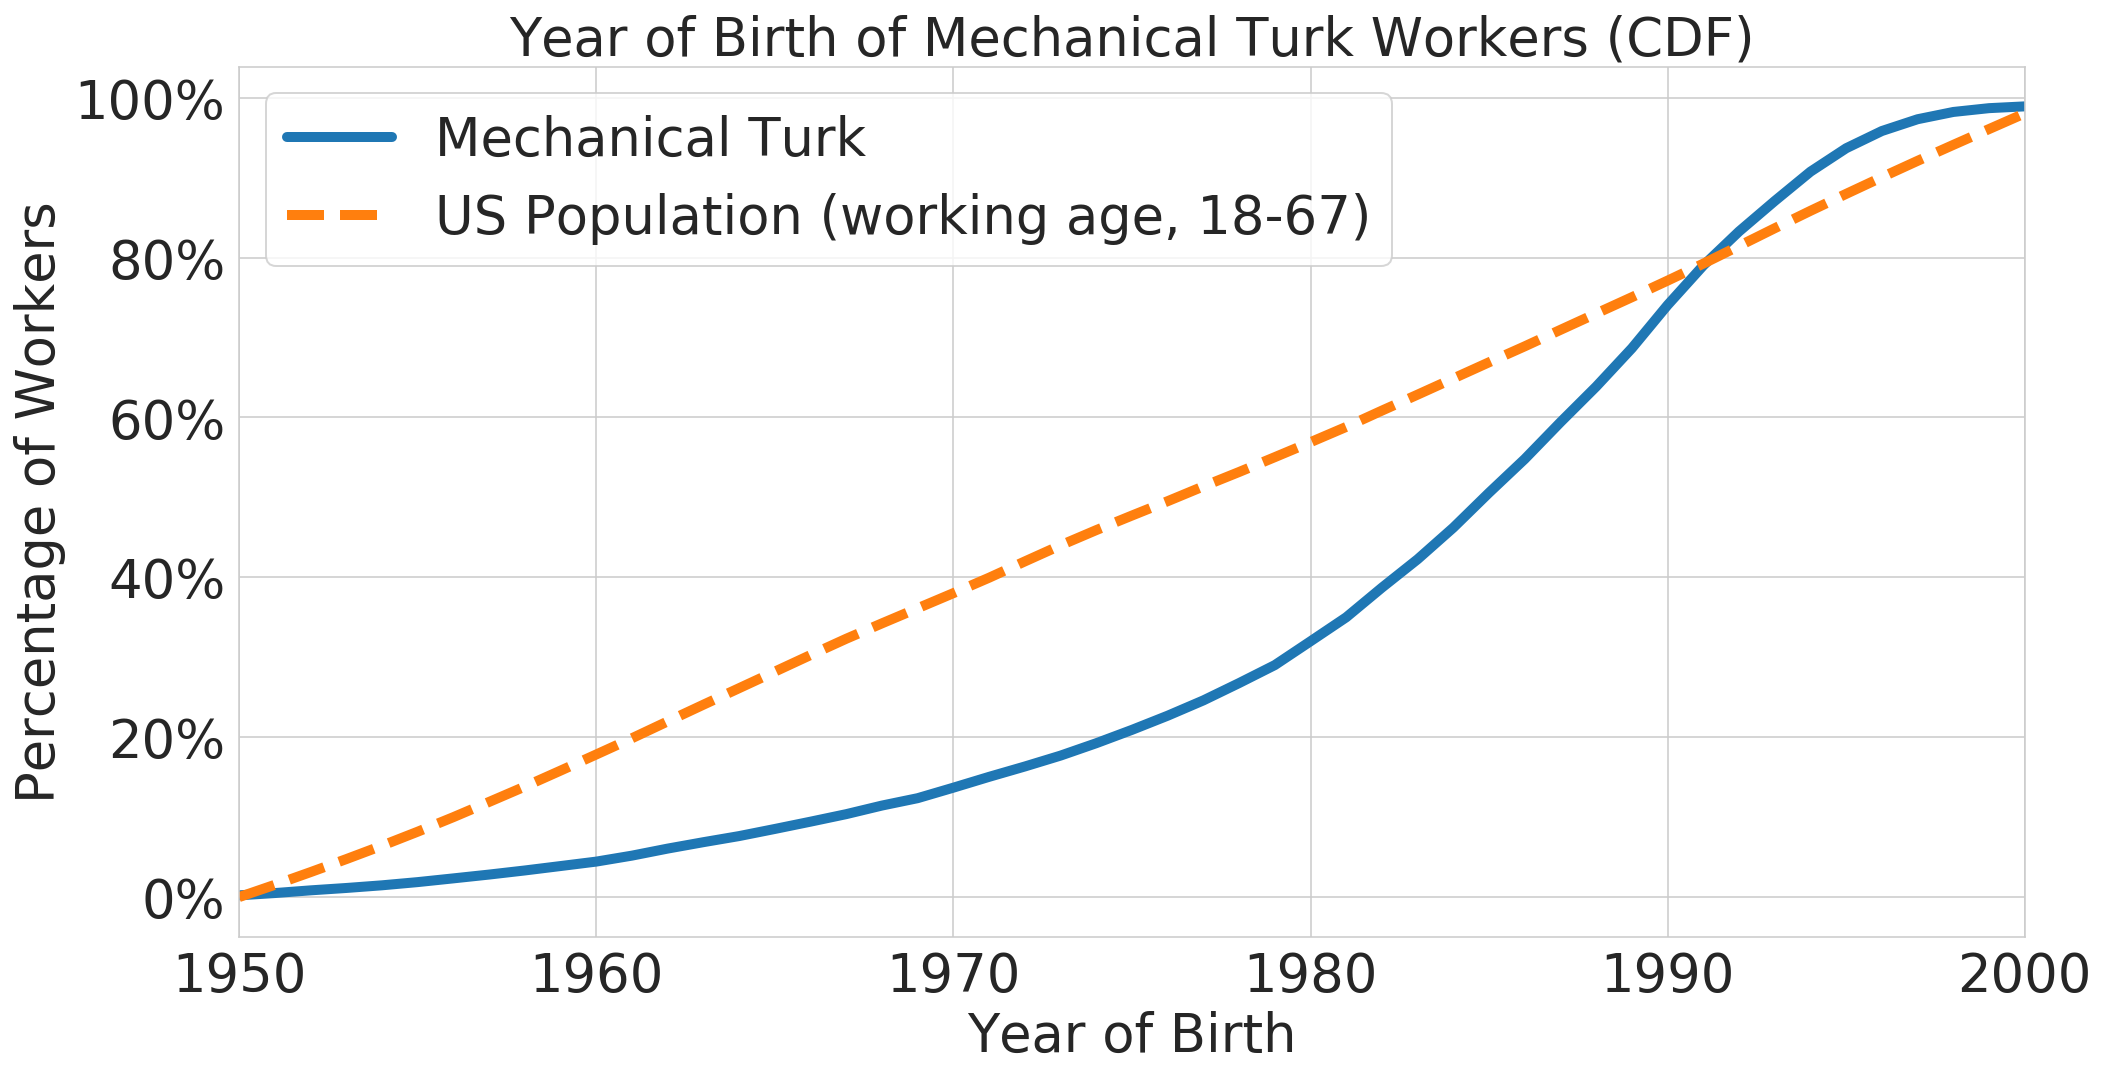

In [53]:
# Limit data to working age
years = [y for y in range(1950,2001)]

# 
yob_df = (100*yob_table[years].mean()).cumsum()
ax = yob_df.plot(fontsize='large', linewidth=5)
ax.set_title("Year of Birth of Mechanical Turk Workers (CDF)", fontsize='large')
ax.set_xlabel("Year of Birth", fontsize='large')
ax.set_ylabel("Percentage of Workers", fontsize='large')

fmt = '%.0f%%' # Format you want the ticks, e.g. '40%'
yticks = mtick.FormatStrFormatter(fmt)
ax.yaxis.set_major_formatter(yticks)

census = pd.read_csv("census.csv", sep='\t', names  = ['Year of Birth', 'U', 'US Population'])
census.set_index('Year of Birth', inplace=True)
census.drop('U',axis=1, inplace=True)
census.sort_index(inplace=True)
census['US Population'] = 100*census['US Population']
census.plot(ax=ax, linestyle='--', linewidth=5)

ax.legend(['Mechanical Turk', 'US Population (working age, 18-67)'], fontsize='large')

fig = ax.get_figure()
fig.savefig('plots/yearofbirth.pdf', bbox_inches='tight')

In [54]:

census.dtypes

US Population    float64
dtype: object

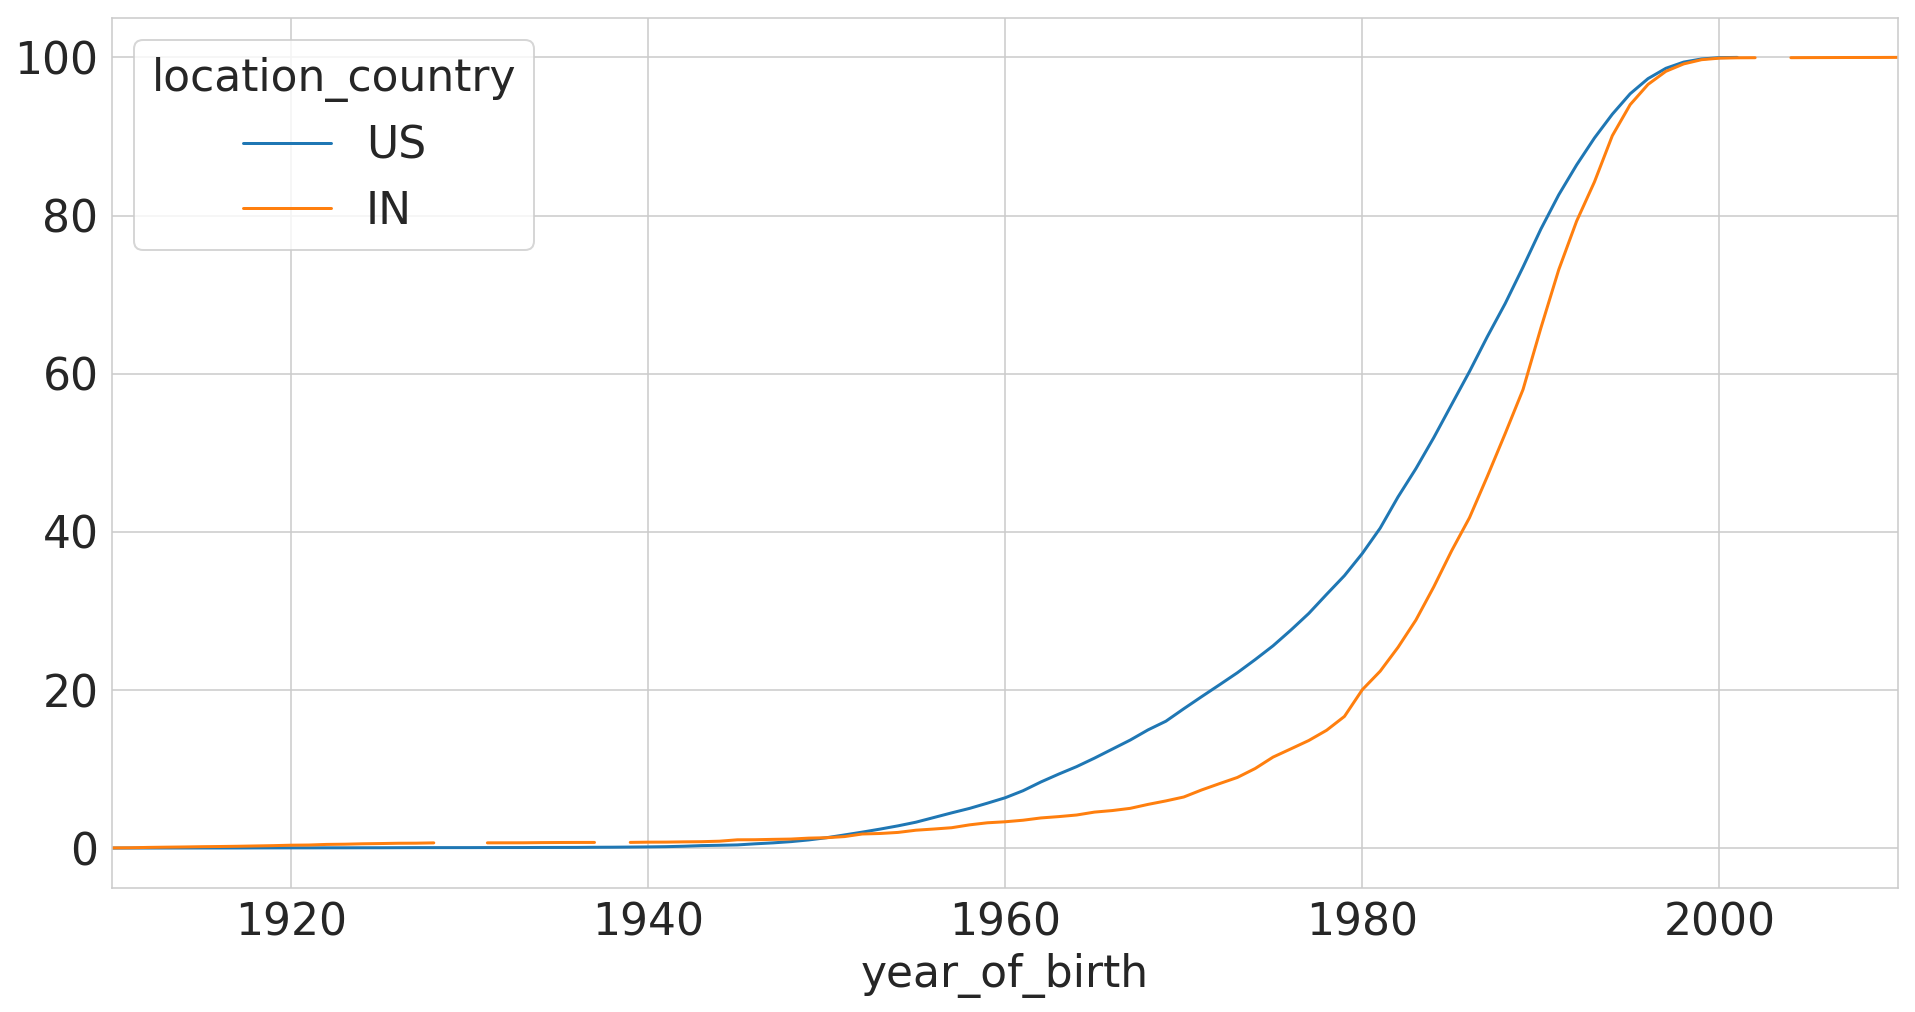

In [55]:
age_by_country = pd.pivot_table(data=df,
                             values='worker_id', 
                             aggfunc=np.count_nonzero,
                             index=df.year_of_birth,
                             columns=df.location_country)

age_by_country = age_by_country[['US', 'IN']]
age_by_country = 100*age_by_country / age_by_country.sum()
# age_by_country.plot(ax = ax)
# fig
age_by_country.cumsum().plot()

In [56]:
# Keep only US and India

# Normalize and keep percentages
age_by_country_perc = age_by_country.apply(lambda x: 100*x / float(x.sum()), axis=1).round(2)
# age_by_country_perc = age_by_country_perc.reindex(['US', 'IN', 'CA', 'GB', 'PH', 'DE'])

In [57]:
age_by_country_perc

location_country      US      IN
year_of_birth                   
1910               18.30   81.70
1911               17.00   83.00
1912                3.53   96.47
1913                7.86   92.14
1914                6.01   93.99
1915                4.87   95.13
1916                3.53   96.47
1917                2.77   97.23
1918               14.58   85.42
1919                7.86   92.14
1920                4.32   95.68
1921                3.53   96.47
1922                6.26   93.74
1923                6.01   93.99
1924                7.41   92.59
1925                5.38   94.62
1926               17.32   82.68
1927               43.44   56.56
1928                4.09   95.91
1929              100.00     NaN
1930              100.00     NaN
1931               64.18   35.82
1932               43.44   56.56
1933               33.86   66.14
1934               26.78   73.22
1935               20.38   79.62
1936               33.86   66.14
1937               84.92   15.08
1938              100.00     NaN
1939               84.31   15.69
...                  ...     ...
1981               57.81   42.19
1982               56.65   43.35
1983               50.91   49.09
1984               48.29   51.71
1985               47.87   52.13
1986               49.93   50.07
1987               45.78   54.22
1988               43.60   56.40
1989               45.31   54.69
1990               38.18   61.82
1991               37.02   62.98
1992               38.08   61.92
1993               40.71   59.29
1994               33.97   66.03
1995               39.70   60.30
1996               42.78   57.22
1997               44.05   55.95
1998               45.66   54.34
1999               42.51   57.49
2000               45.96   54.04
2001               41.48   58.52
2002                 NaN  100.00
2003              100.00     NaN
2004                 NaN  100.00
2005                 NaN  100.00
2006               20.38   79.62
2007                 NaN  100.00
2008               20.38   79.62
2009                 NaN  100.00
2010                 NaN  100.00

[101 rows x 2 columns]

##### Decade of birth

In [58]:
df['yob_decade'] = df['year_of_birth'].apply(lambda x: str(int(round(x,-1)))+'-'+str(int(round(x,-1))+9))
decades = ['1950-1959', '1960-1969', '1970-1979', '1980-1989', '1990-1999','2000-2009']
yob_table = pd.crosstab(index=df.date, columns=df.yob_decade, 
                            values='worker_id', aggfunc=np.count_nonzero, normalize='index')

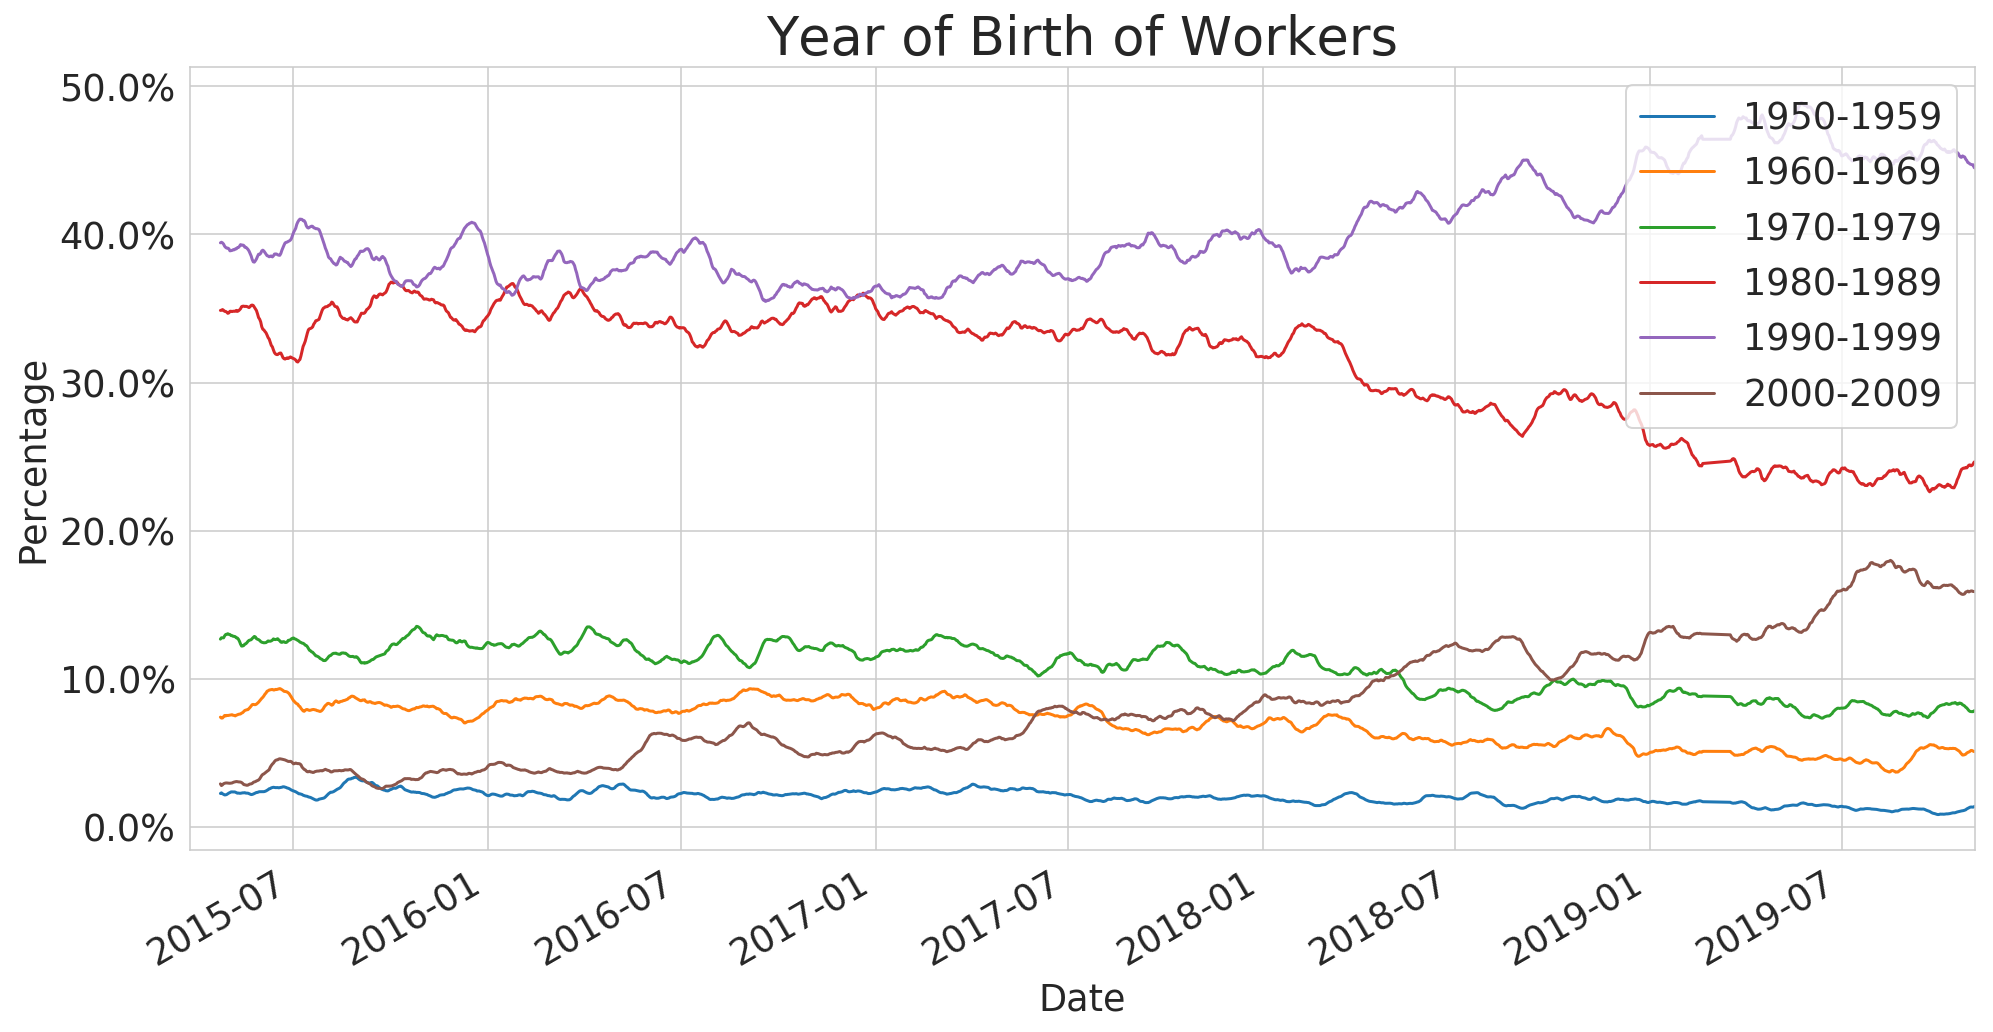

In [59]:
time_plot(100*yob_table[decades], "Year of Birth of Workers", 
          filename = 'plots/decateofbirth.pdf', confidence = False, legend = True)

#### Indian workers are *slightly* younger

In [60]:
data = pd.DataFrame(df[df.location_country=='IN'])
yob_table_in = pd.crosstab(index=data.date, columns=data.yob_decade, 
                            values='worker_id', aggfunc=np.count_nonzero, normalize='index')

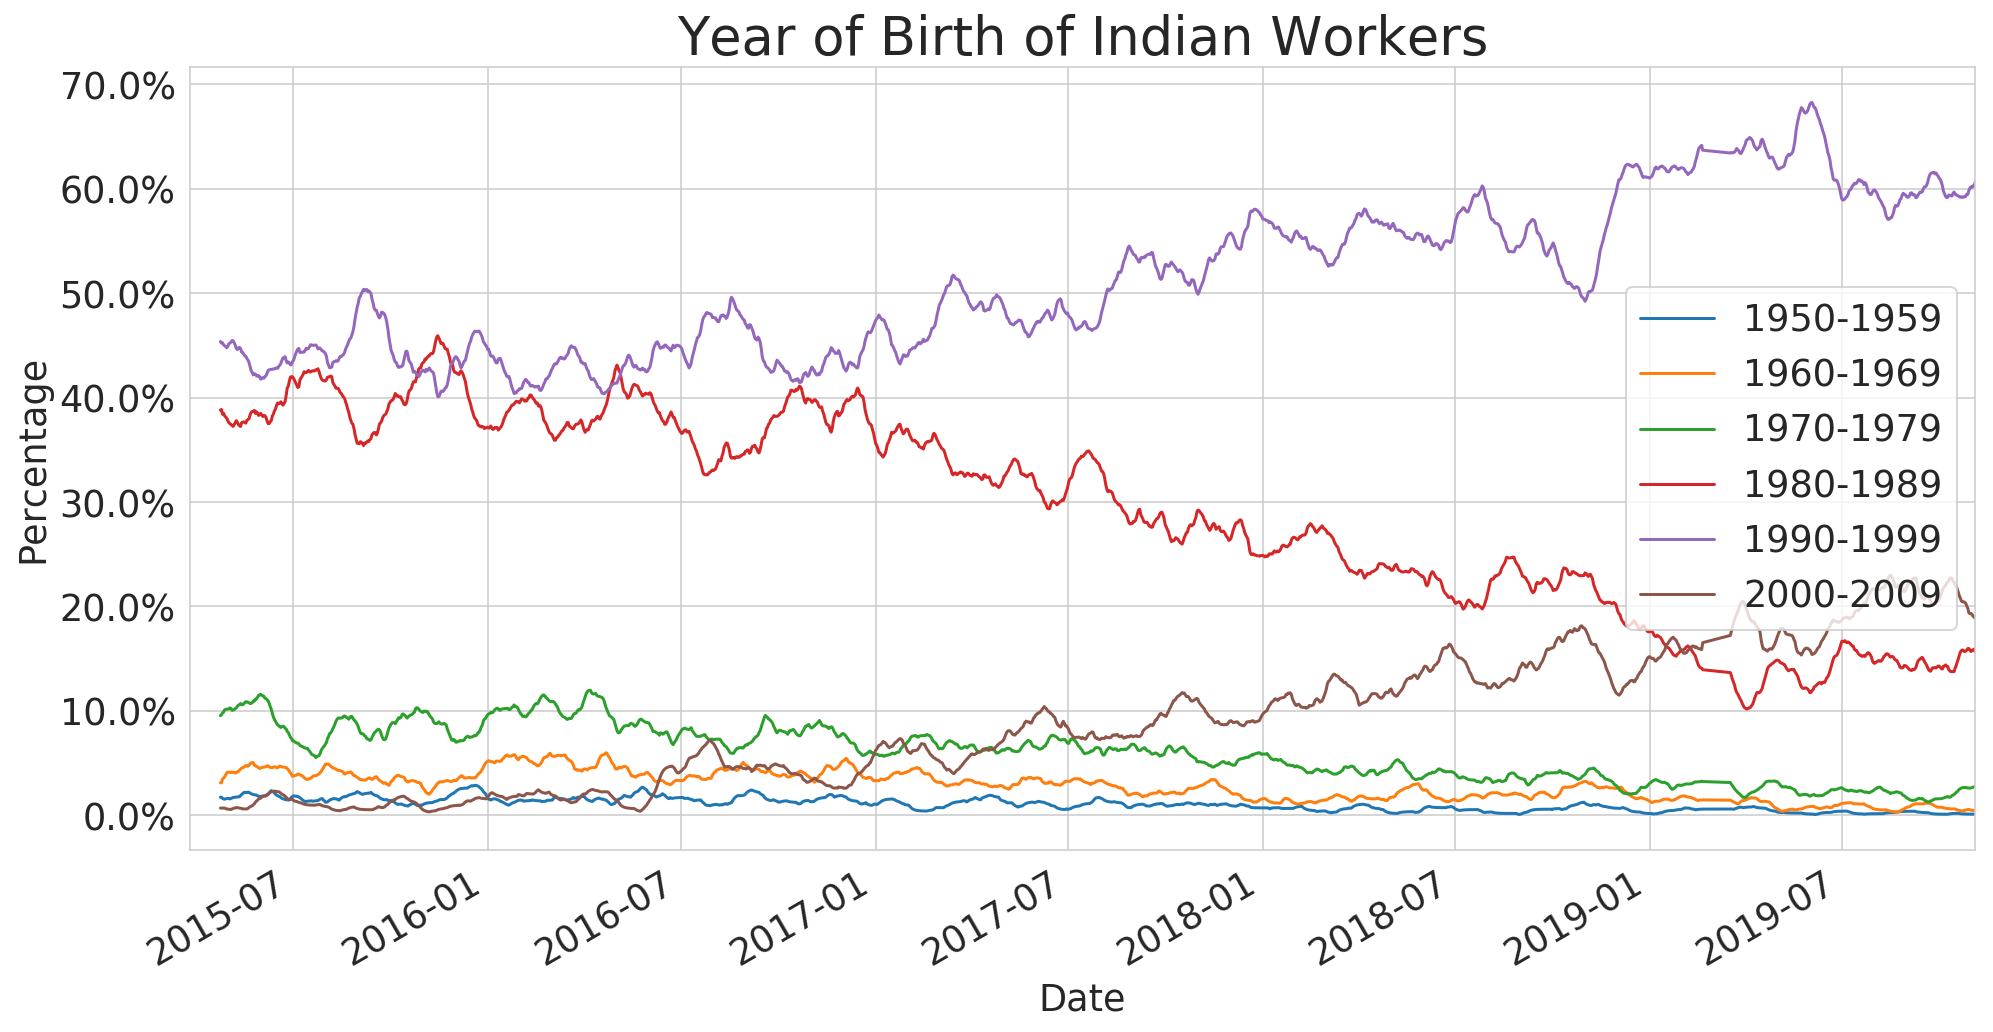

In [61]:
time_plot(100*yob_table_in[decades], "Year of Birth of Indian Workers", 
          'plots/yearofbirth-indian.pdf', confidence = False, legend = True)

### Marital Status

In [62]:
marital_status = pd.pivot_table(data=df,
                             values='worker_id', 
                             aggfunc=np.count_nonzero,
                             index=df.marital_status)

In [63]:
status = set(df.marital_status)
status.discard('None')
status.discard('separated')
status.discard('widowed')
status = sorted(status)
status

['cohabitating', 'divorced', 'engaged', 'married', 'single']

In [64]:
marital_status = 100* marital_status / marital_status.sum()
marital_status = marital_status.T[status].T

In [65]:
marital_status

worker_id
marital_status           
cohabitating     9.016742
divorced         4.848817
engaged          2.645930
married         42.270792
single          41.204779

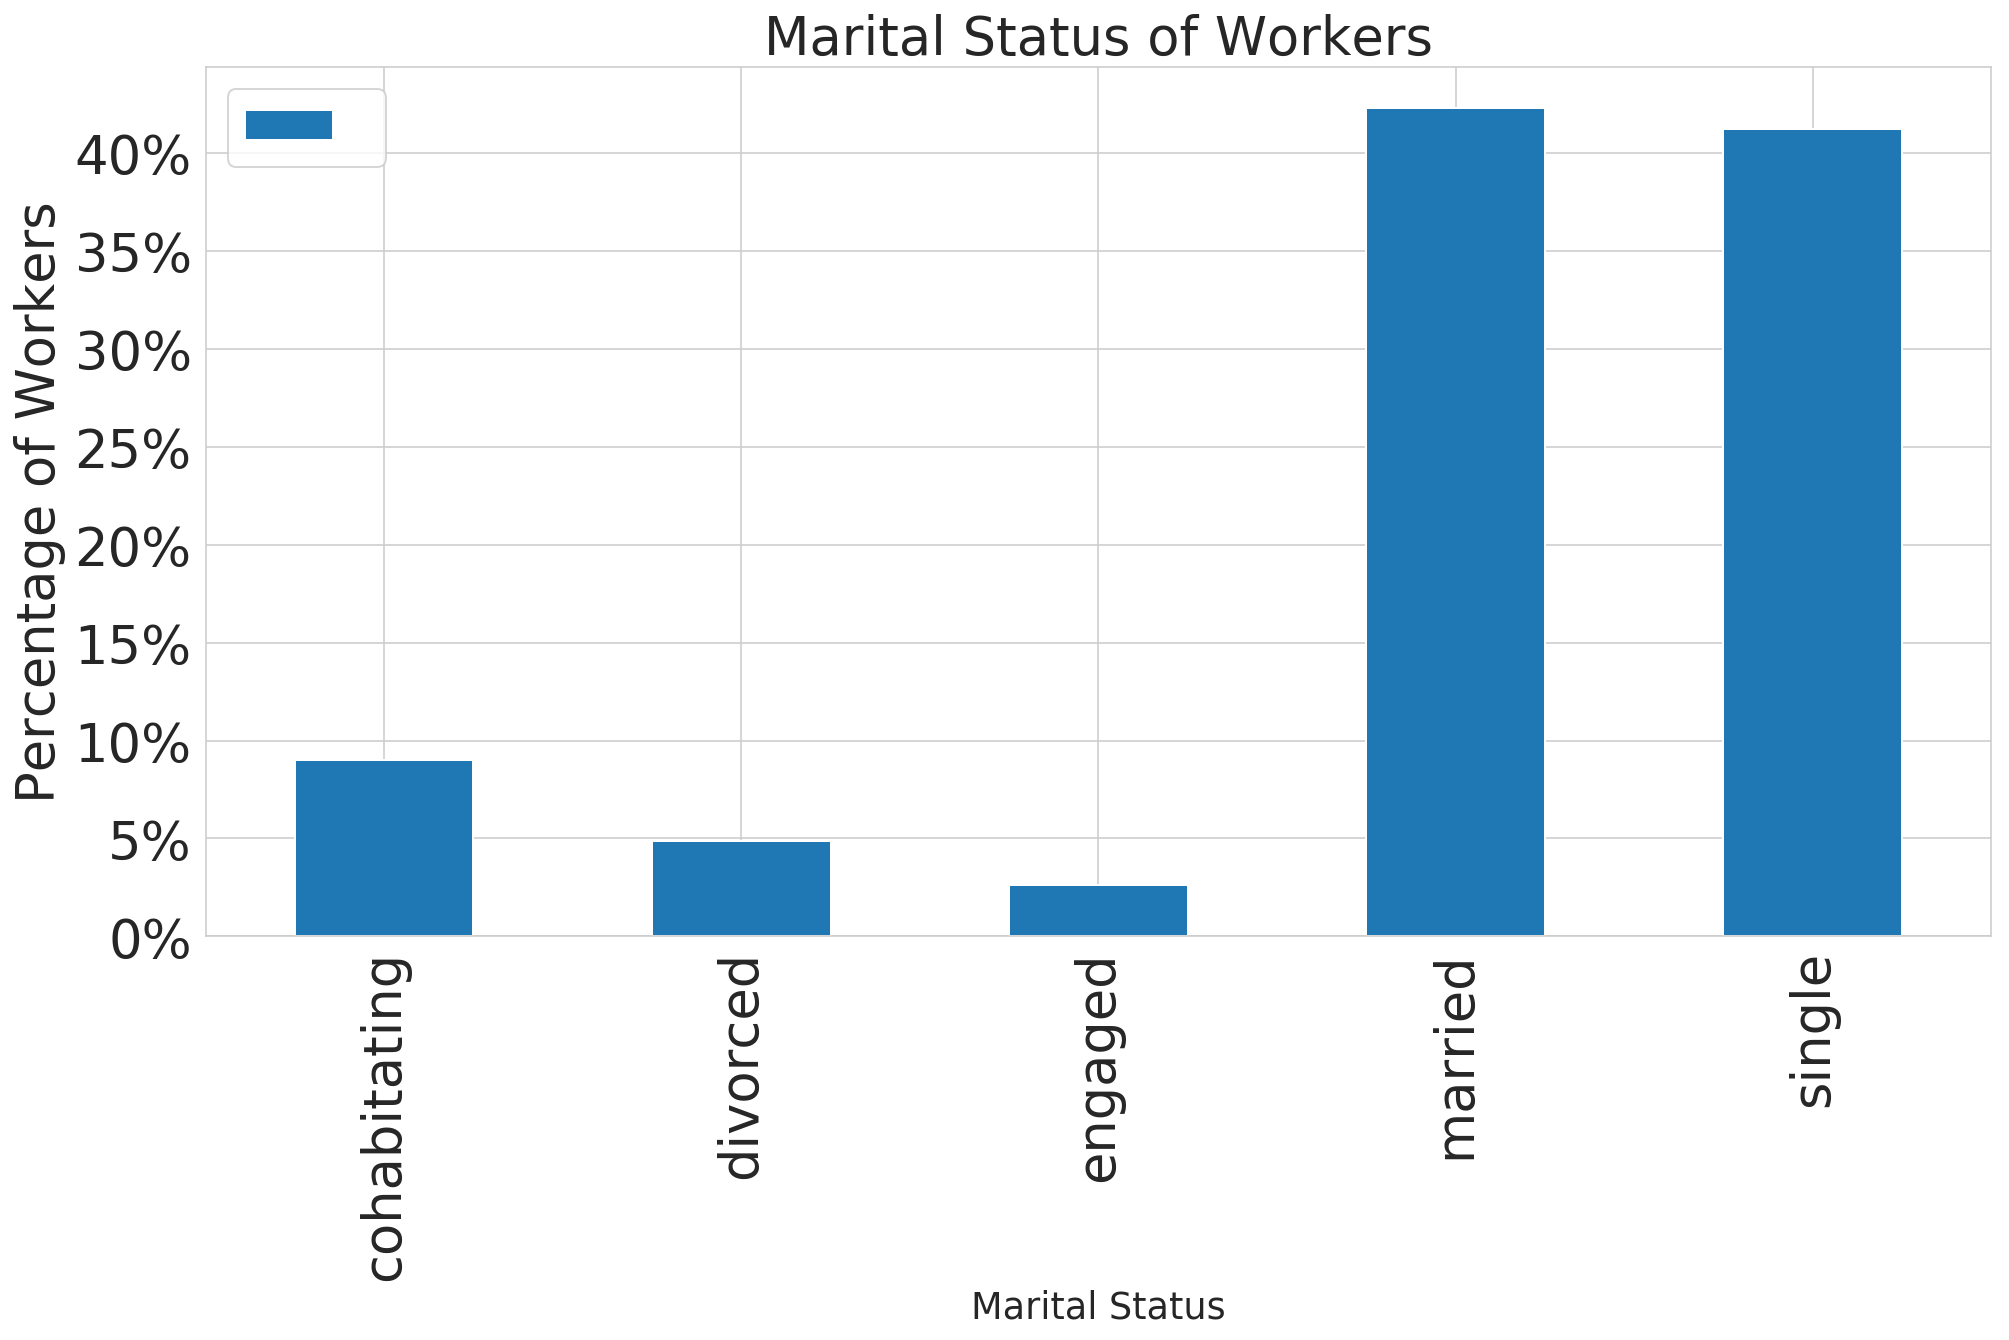

In [66]:
ax = marital_status.plot.bar(fontsize='large')
ax.set_title("Marital Status of Workers", fontsize='large')
ax.set_xlabel("Marital Status", fontsize='small')
ax.set_ylabel("Percentage of Workers", fontsize='large')
ax.legend([''])

fmt = '%.0f%%' # Format you want the ticks, e.g. '40%'
yticks = mtick.FormatStrFormatter(fmt)
ax.yaxis.set_major_formatter(yticks)

fig = ax.get_figure()
fig.savefig('plots/marital-status.pdf', bbox_inches='tight')

In [67]:
married_table = pd.crosstab(index=df.date, columns=df.marital_status, 
                            values='worker_id', aggfunc=np.count_nonzero, normalize='index')

In [68]:
status = set(df.marital_status)
status.discard('None')
status.discard('separated')
status.discard('widowed')
status = sorted(status)
status

['cohabitating', 'divorced', 'engaged', 'married', 'single']

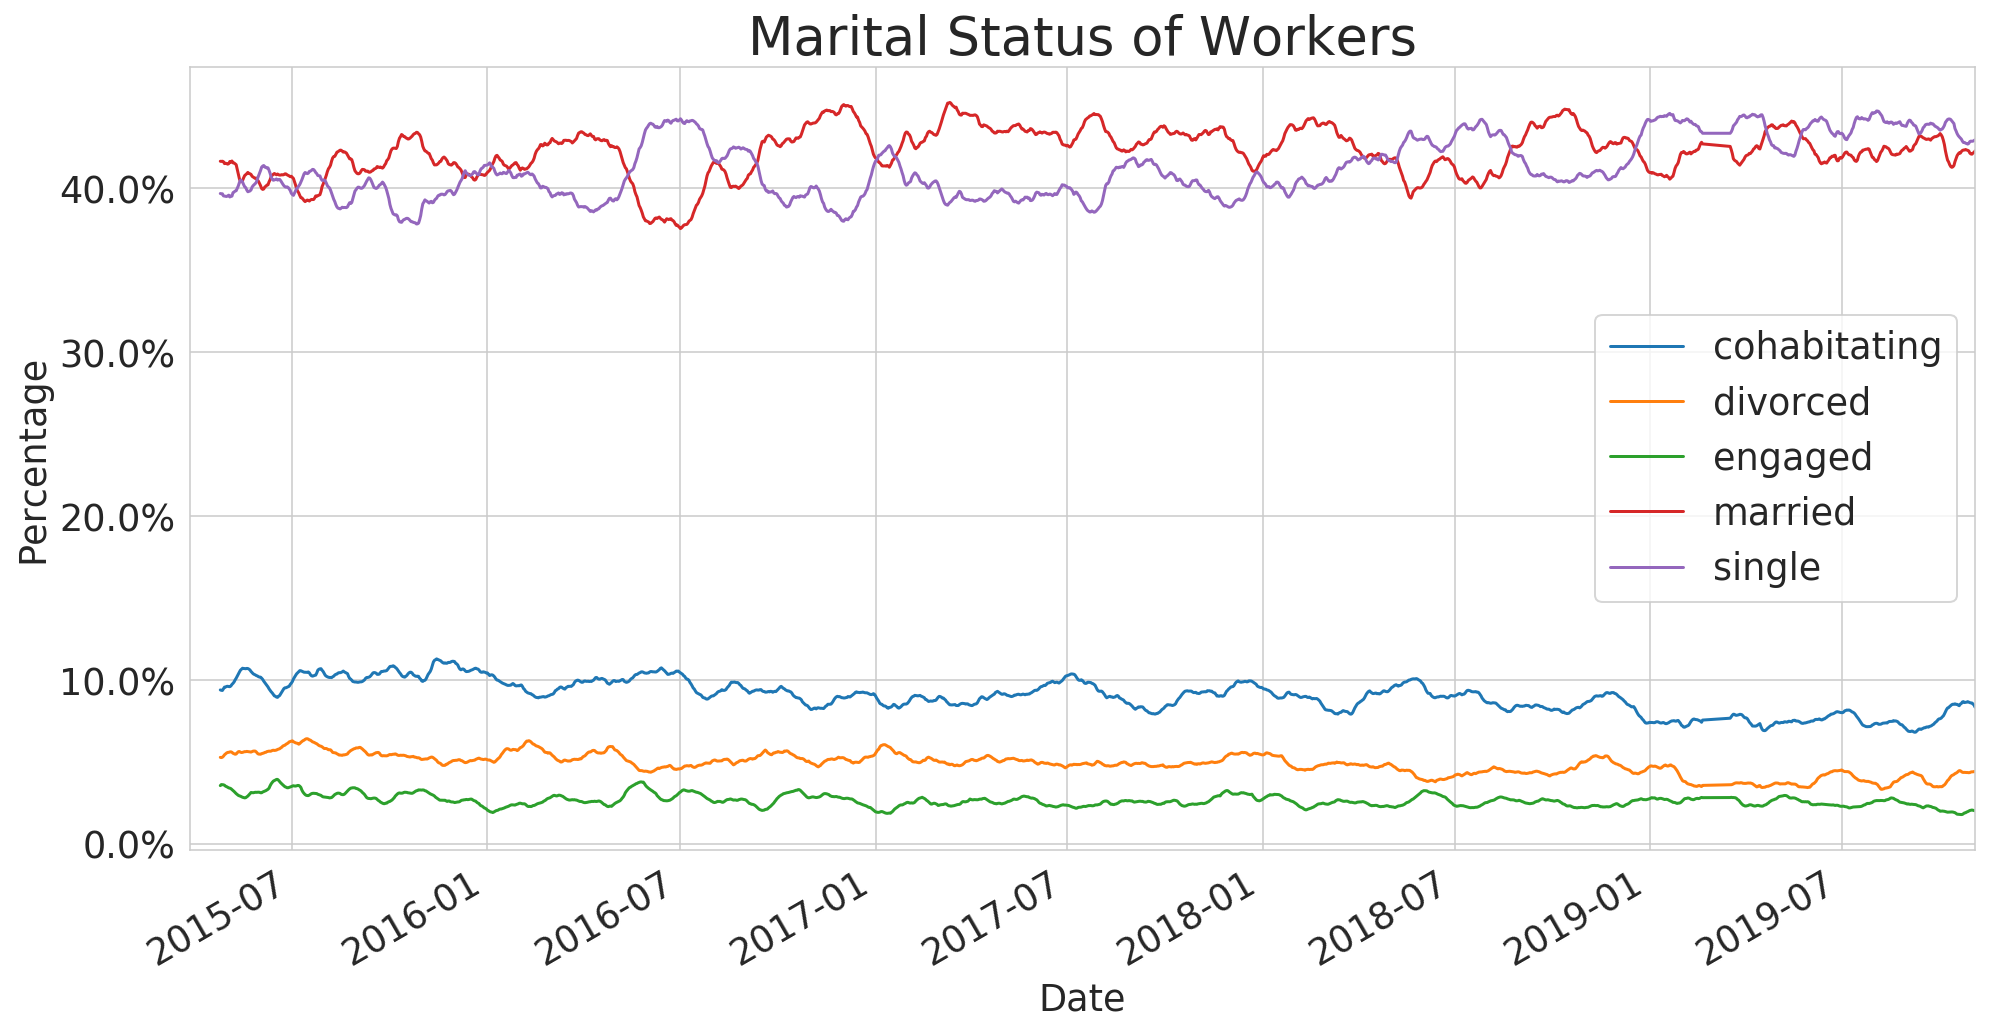

In [69]:
time_plot(100*married_table[status], "Marital Status of Workers", 
          'plots/marital-status.pdf', confidence = False, legend = True)

In [70]:
married_table_in = pd.crosstab(index=df[df.location_country=='IN'].date, columns=df[df.location_country=='IN'].marital_status, 
                            values='worker_id', aggfunc=np.count_nonzero, normalize='index')

In [71]:
status = set(df.marital_status)
status.discard('None')
status.discard('separated')
status.discard('widowed')
status.discard('engaged')
status.discard('divorced')
status.discard('cohabitating')
status = sorted(status)
status

['married', 'single']

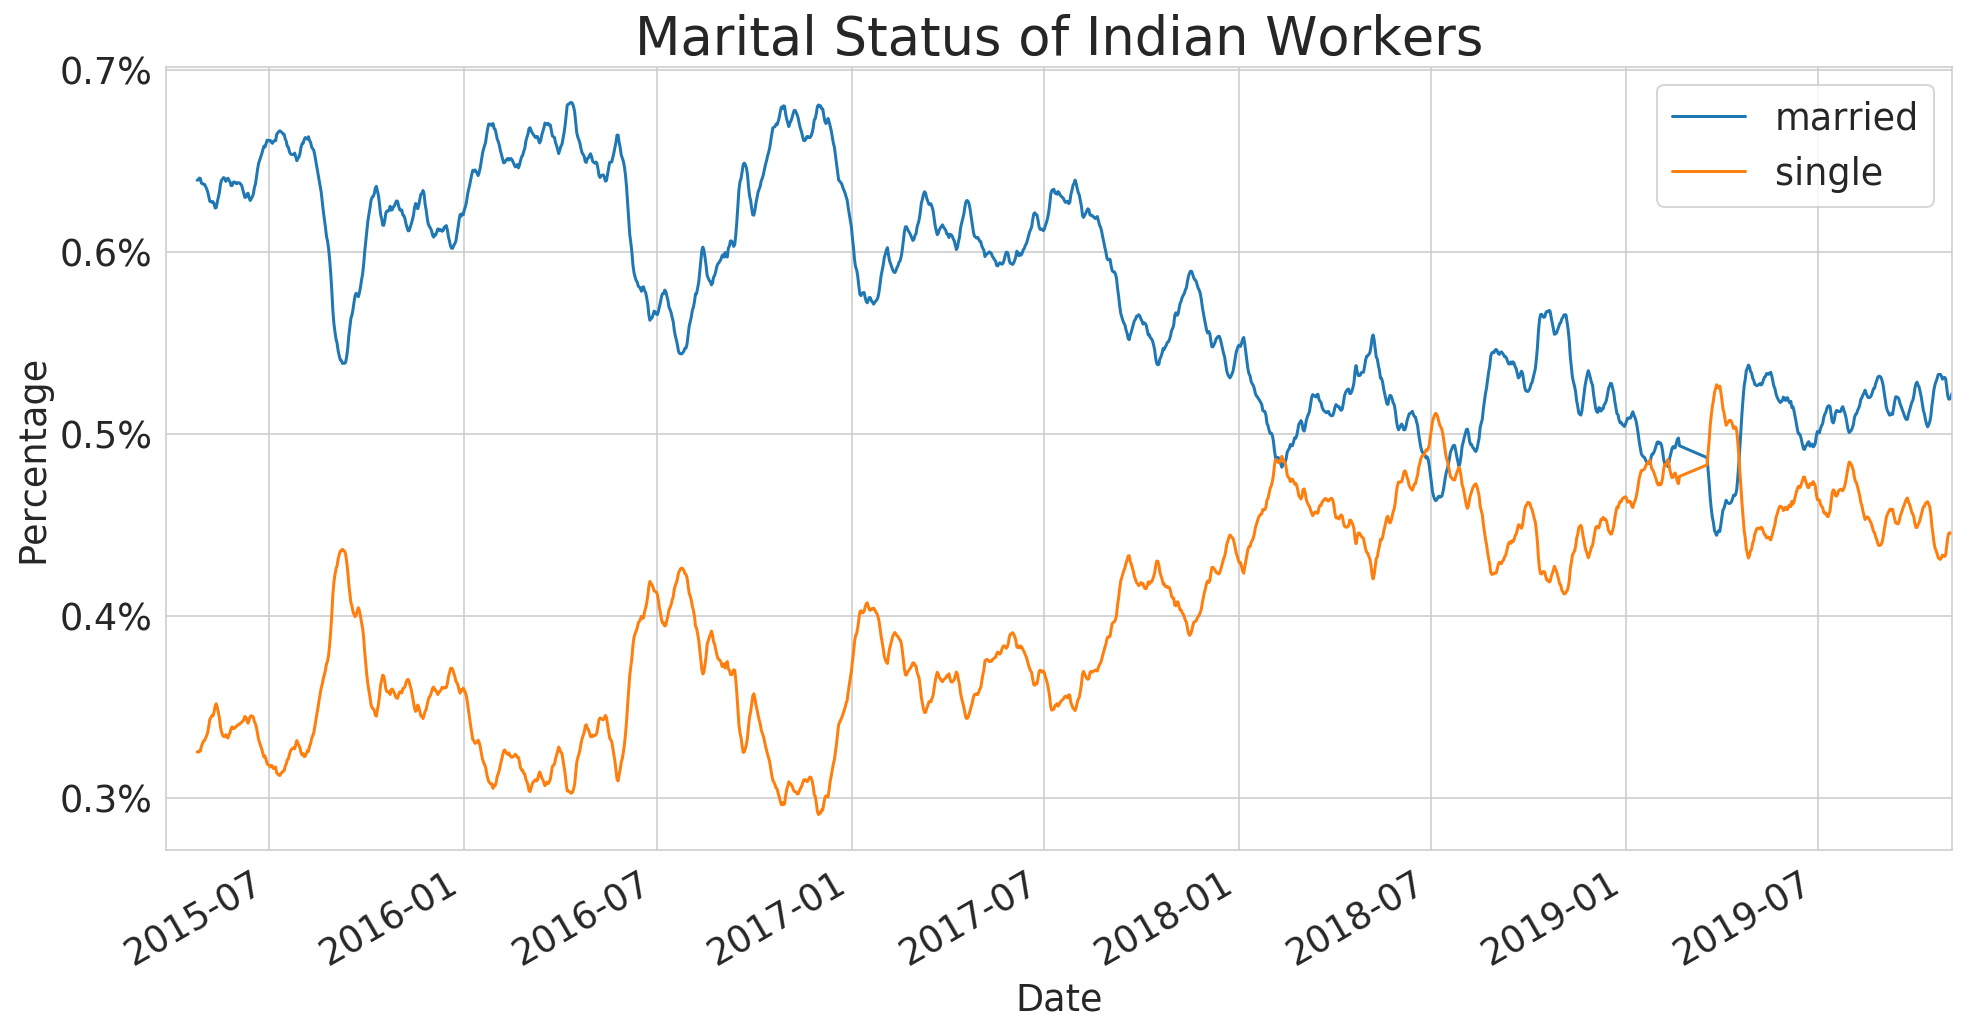

In [72]:
time_plot(married_table_in[status], "Marital Status of Indian Workers",
          'plots/marital-status-indian.pdf', confidence = False, legend = True)

### Household Size



In [73]:
hhsize_table = pd.crosstab(index=df.date, columns=df.household_size, 
                           values='worker_id', aggfunc=np.count_nonzero, normalize='index')

In [74]:
status = sorted(set(df.household_size))

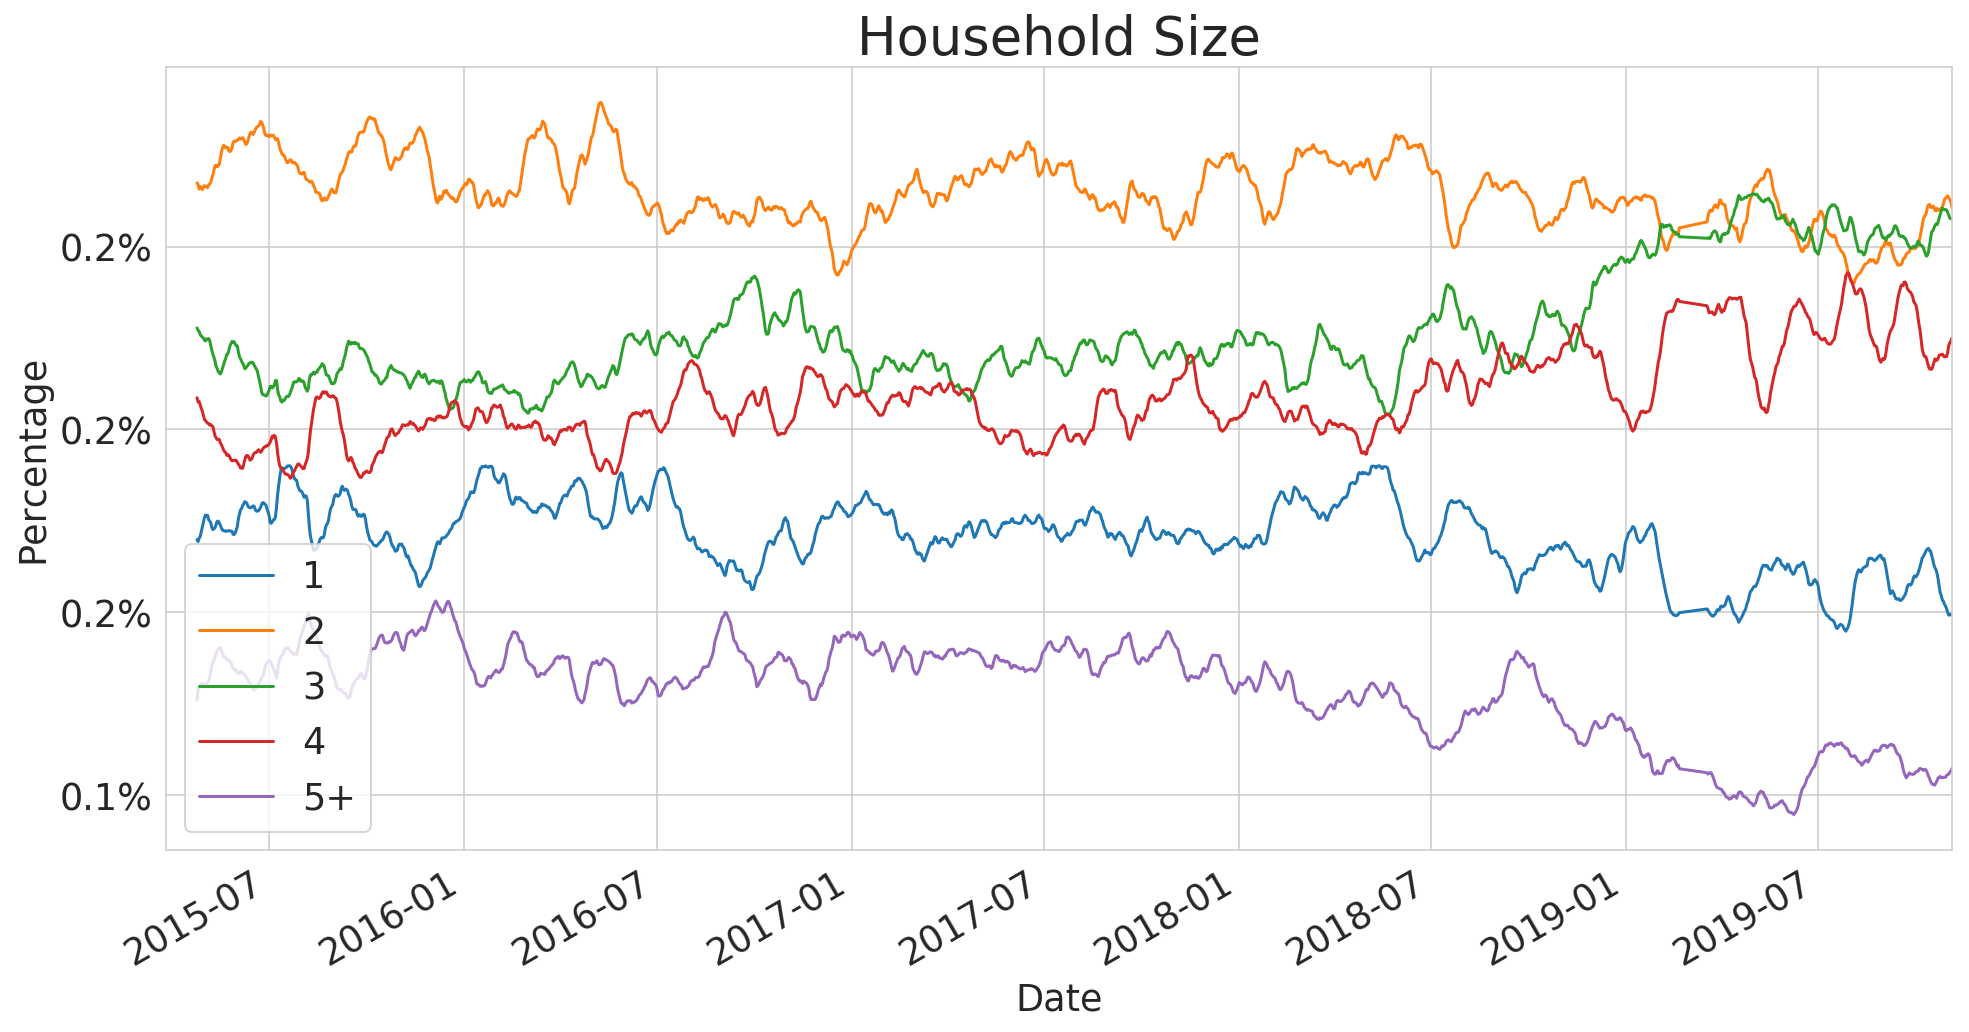

In [75]:
time_plot(hhsize_table[status], "Household Size",
          'plots/hhsize.pdf', confidence = False, legend = True)

#### HHSize for Single and Married People

In [76]:
hhsize_table = pd.crosstab(index=df.date, columns=[df.household_size, df.marital_status], 
                           values='worker_id', aggfunc=np.count_nonzero, normalize='index')

In [77]:
import itertools

marital = set(df.marital_status)
marital.discard('None')
marital.discard('separated')
marital.discard('widowed')
marital.discard('engaged')
marital.discard('divorced')
marital.discard('cohabitating')
# marital.discard('single')
marital.discard('married')


hhsize = set(df.household_size)
# hhsize.discard('1')
# hhsize.discard('2')
# hhsize.discard('3')
# hhsize.discard('4')
# hhsize.discard('5+')

status = sorted(itertools.product(hhsize, marital))
status

[('1', 'single'),
 ('2', 'single'),
 ('3', 'single'),
 ('4', 'single'),
 ('5+', 'single')]

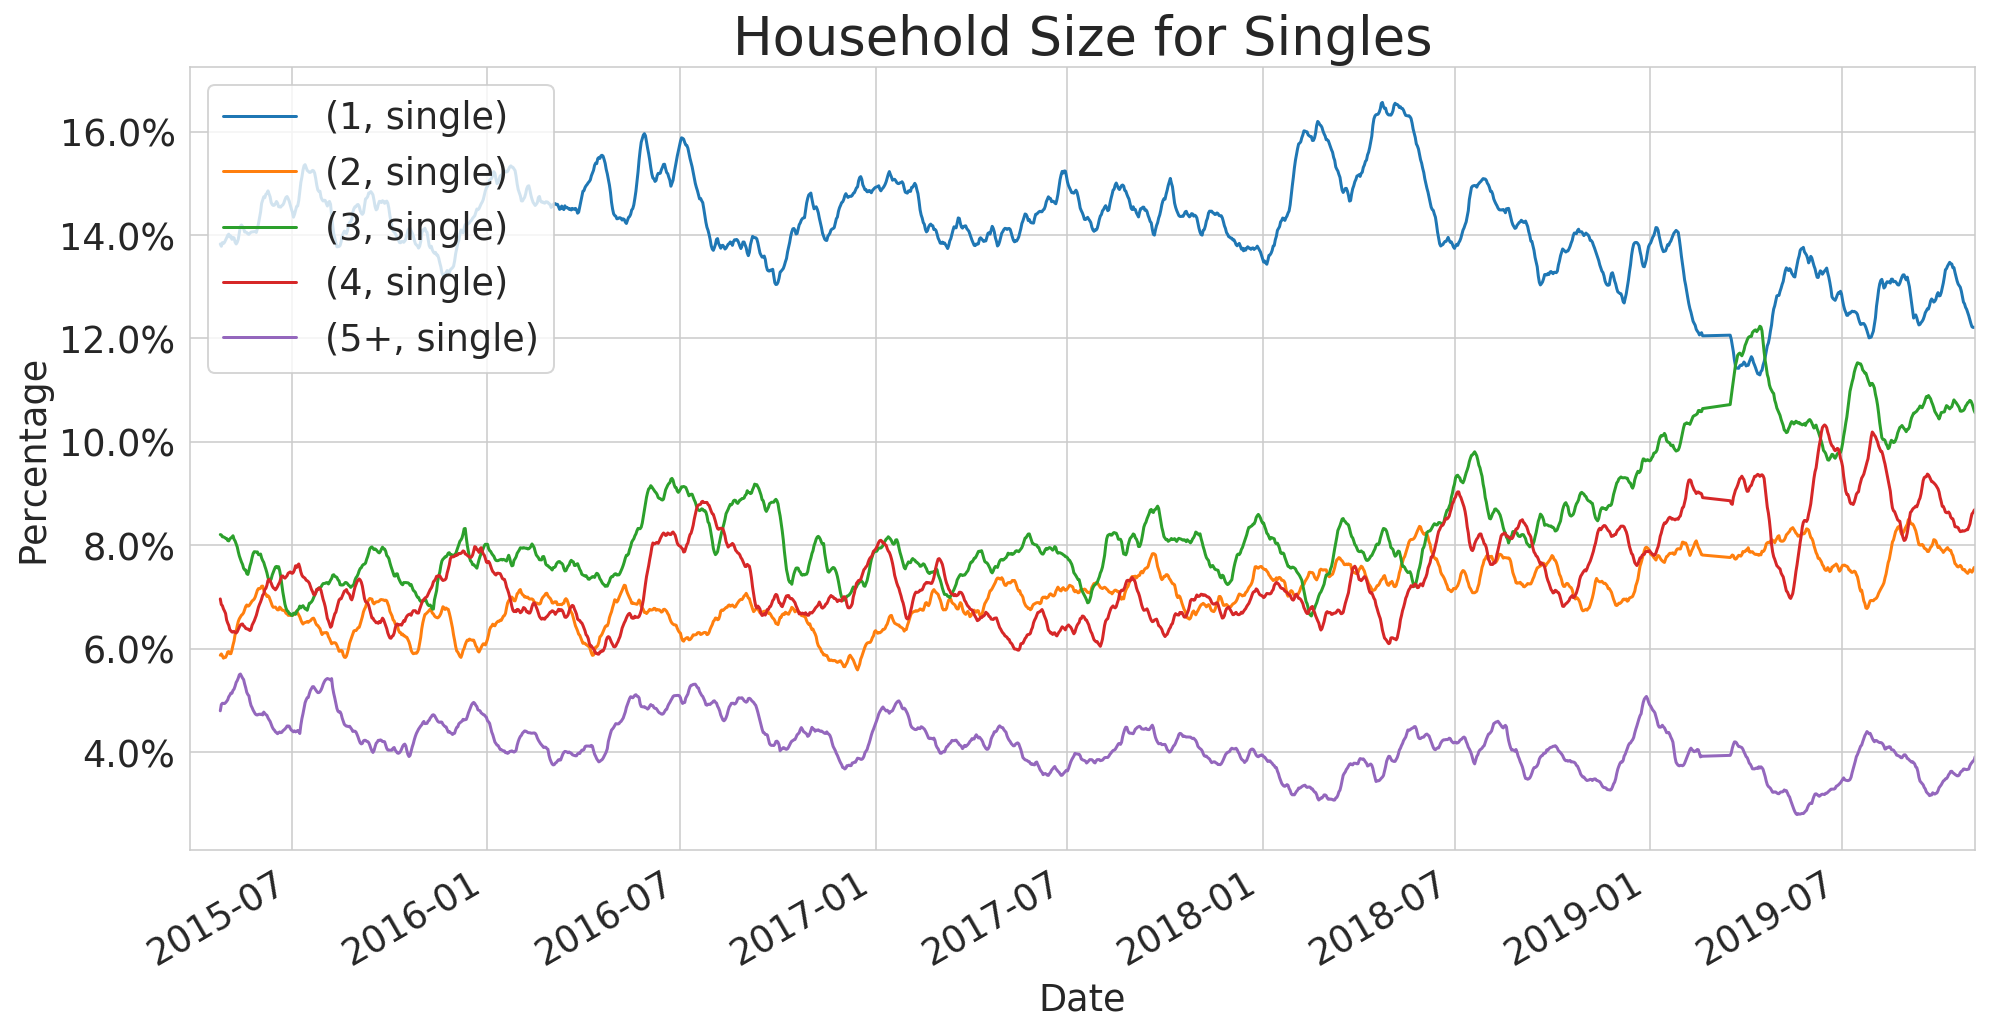

In [78]:
time_plot(100*hhsize_table[status], "Household Size for Singles", 'plots/hhsize-singles.pdf', confidence = False, legend = True)

In [79]:
import itertools

marital = set(df.marital_status)
marital.discard('None')
marital.discard('separated')
marital.discard('widowed')
marital.discard('engaged')
marital.discard('divorced')
marital.discard('cohabitating')
marital.discard('single')
# marital.discard('married')


hhsize = set(df.household_size)
# hhsize.discard('1')
# hhsize.discard('2')
# hhsize.discard('3')
# hhsize.discard('4')
# hhsize.discard('5+')

status = sorted(itertools.product(hhsize, marital))
status

[('1', 'married'),
 ('2', 'married'),
 ('3', 'married'),
 ('4', 'married'),
 ('5+', 'married')]

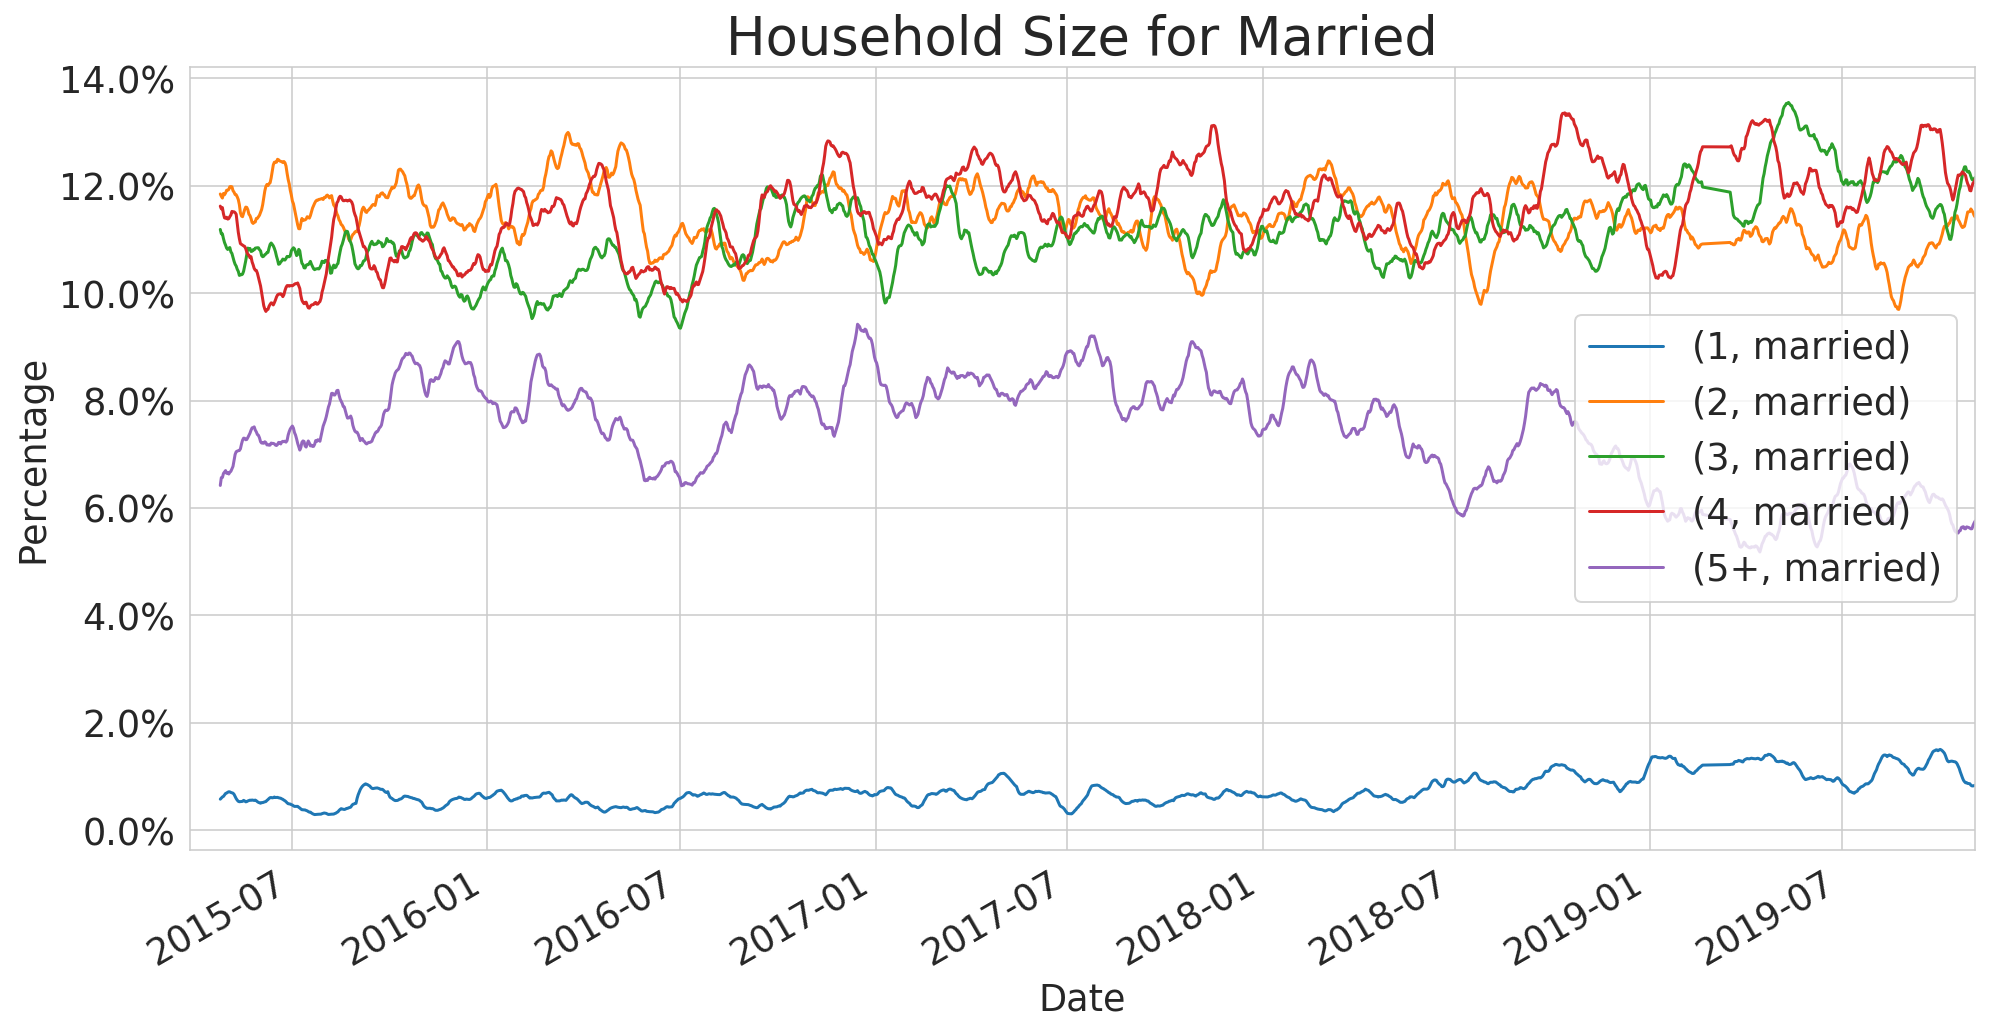

In [80]:
time_plot(100*hhsize_table[status], "Household Size for Married", 'plots/hhsize-married.pdf', confidence = False, legend = True)

### Household Income

In [81]:
df['household_income'] = df['household_income'].apply(lambda x:x.replace('$',''))
income = pd.pivot_table(data=df[df.location_country=='US'],
                             values='worker_id', 
                             aggfunc=np.count_nonzero,
                             index=df[df.location_country=='US'].household_income)

In [82]:
status = sorted(set(df.household_income))
# Reconfiguring the order
status[0],  status[1], status[7] = status[7], status[0], status[1]
income = income.reindex(status)
income = income / income.sum()
income_df = income.cumsum()*100
income_df

worker_id
household_income            
Less than 10,000    5.891986
10,000-14,999      10.553646
15,000-24,999      20.883289
25,000-39,999      39.282169
40,000-59,999      60.574435
60,000-74,999      73.840736
75,000-99,999      86.460481
100,000 or more   100.000000

In [83]:
# https://en.wikipedia.org/wiki/Household_income_in_the_United_States
census_income_dict = [
{'household_income': 'Less than 10,000', 'US Population' : 3.67},
{'household_income': '10,000-14,999',  'US Population'  : 7.14},
{'household_income': '15,000-24,999',  'US Population' : 18.01},
{'household_income': '25,000-39,999',  'US Population' : 33.63},
{'household_income': '40,000-59,999',  'US Population' : 50.83},
{'household_income': '60,000-74,999',  'US Population' : 60.79},
{'household_income': '75,000-99,999',  'US Population' : 73.45},
{'household_income': '100,000 or more',  'US Population' : 100},   
]
census = pd.DataFrame(census_income_dict)
census.set_index('household_income', inplace=True)


In [84]:
census

US Population
household_income               
Less than 10,000           3.67
10,000-14,999              7.14
15,000-24,999             18.01
25,000-39,999             33.63
40,000-59,999             50.83
60,000-74,999             60.79
75,000-99,999             73.45
100,000 or more          100.00

In [85]:
df_income = income_df.join(census)
df_income.drop('100,000 or more', inplace=True)

In [86]:
rename_dict = {
    'Less than 10,000': 10000,
    '10,000-14,999':  15000,
    '15,000-24,999':  25000,
    '25,000-39,999': 40000,
    '40,000-59,999': 60000,
    '60,000-74,999': 75000,
    '75,000-99,999': 100000}

df_income.rename(index=rename_dict, inplace=True)
df_income

worker_id  US Population
household_income                          
10000              5.891986           3.67
15000             10.553646           7.14
25000             20.883289          18.01
40000             39.282169          33.63
60000             60.574435          50.83
75000             73.840736          60.79
100000            86.460481          73.45

In [87]:
tmp = pd.DataFrame([{'household_income': 0, 'US Population':0, 'worker_id': 0}]).set_index('household_income')
df_income = df_income.append(tmp).sort_index()

/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


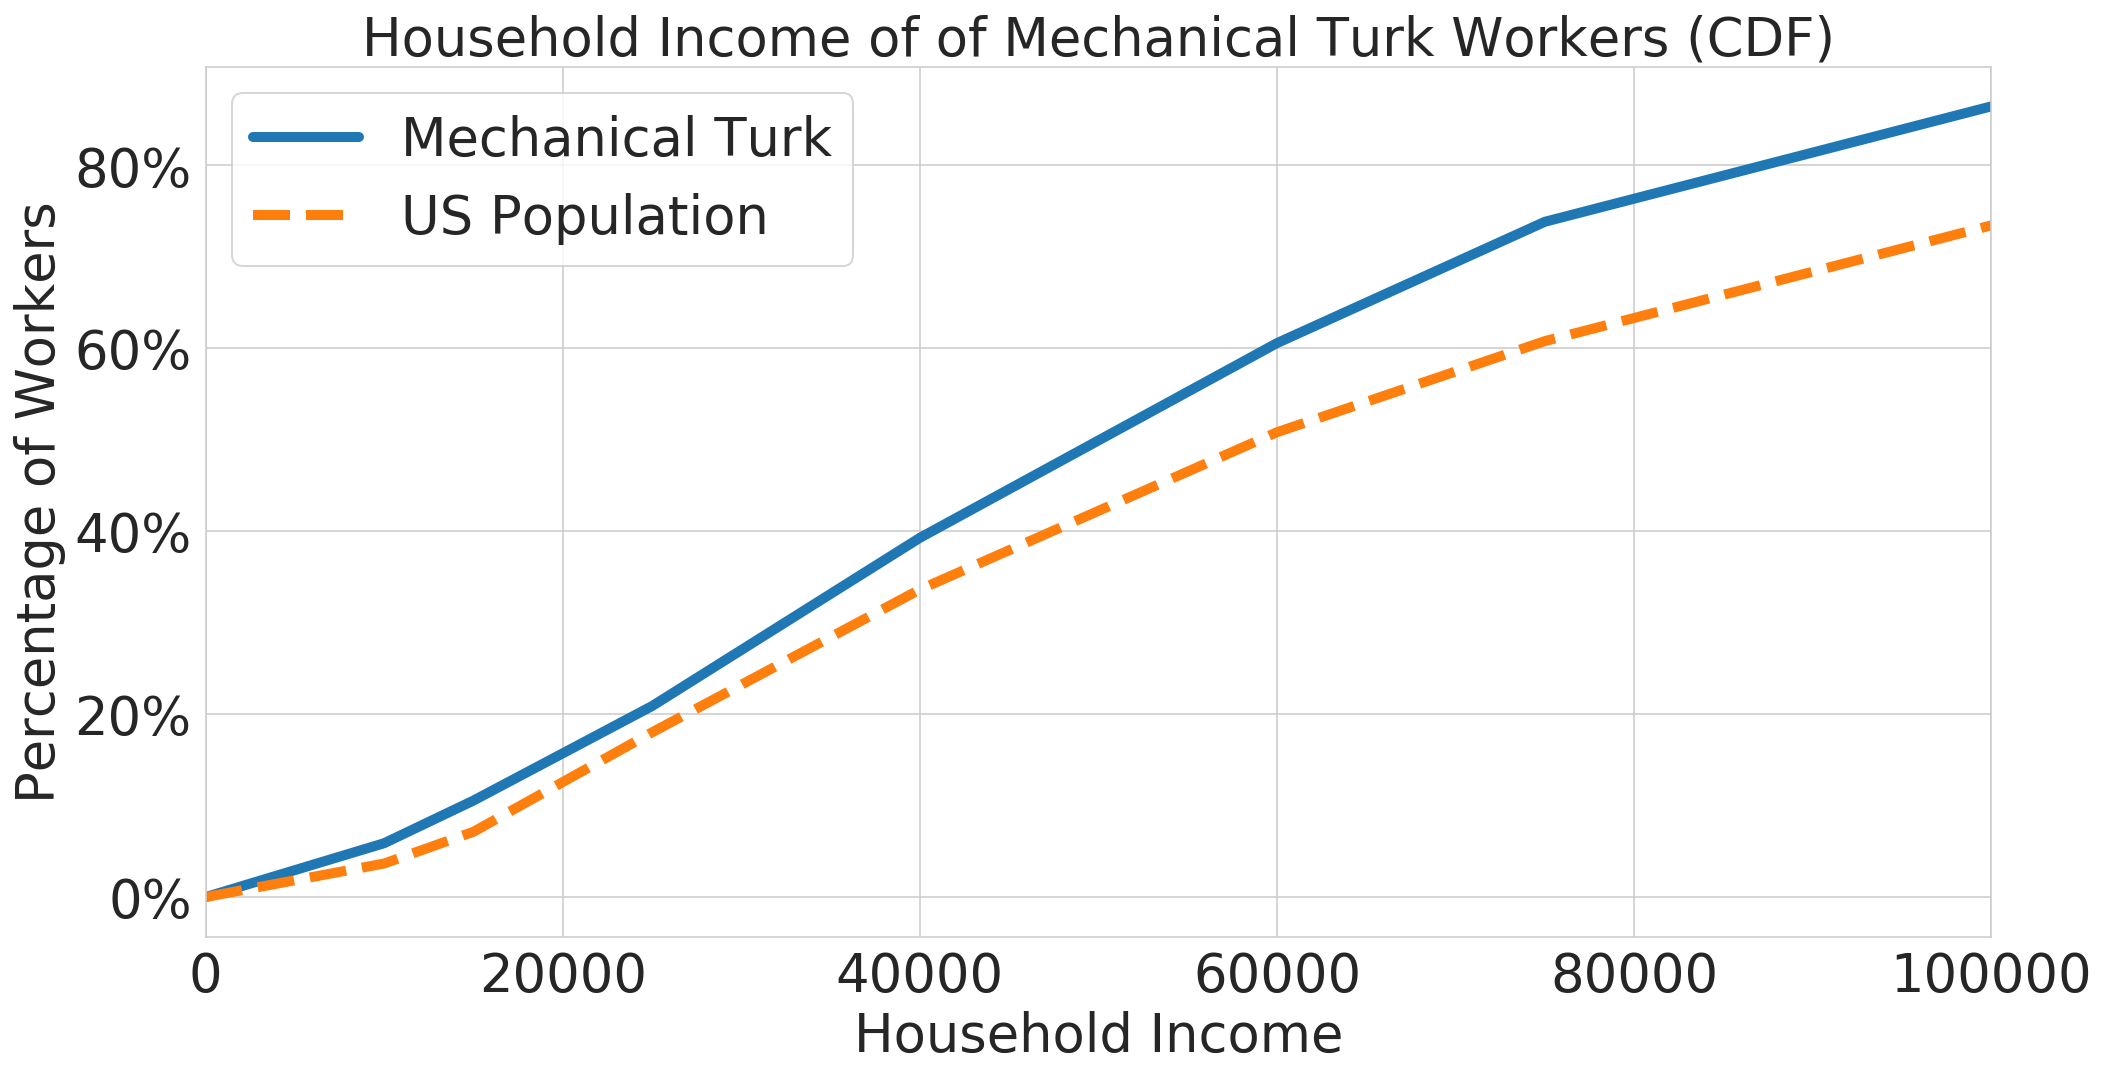

In [88]:
ax = df_income['worker_id'].plot(fontsize='large', linewidth=5)
ax = df_income['US Population'].plot(fontsize='large', linewidth=5, linestyle='--', ax = ax)

fmt = '%.0f%%' # Format you want the ticks, e.g. '40%'
yticks = mtick.FormatStrFormatter(fmt)
ax.yaxis.set_major_formatter(yticks)
ax.set_xlim([0,100000])


ax.set_title("Household Income of of Mechanical Turk Workers (CDF)", fontsize='large')
ax.set_xlabel("Household Income", fontsize='large')
ax.set_ylabel("Percentage of Workers", fontsize='large')

ax.legend(['Mechanical Turk', 'US Population'], fontsize='large')

fig = ax.get_figure()
fig.savefig('plots/income.pdf', bbox_inches='tight')

In [89]:
hhincome_table = pd.crosstab(index=df.date, columns=df.household_income, 
                           values='worker_id', aggfunc=np.count_nonzero, normalize='index')

status = sorted(set(df.household_income))

# Reconfiguring the order
status[0],  status[1], status[7] = status[7], status[0], status[1]
status

['Less than 10,000',
 '10,000-14,999',
 '15,000-24,999',
 '25,000-39,999',
 '40,000-59,999',
 '60,000-74,999',
 '75,000-99,999',
 '100,000 or more']

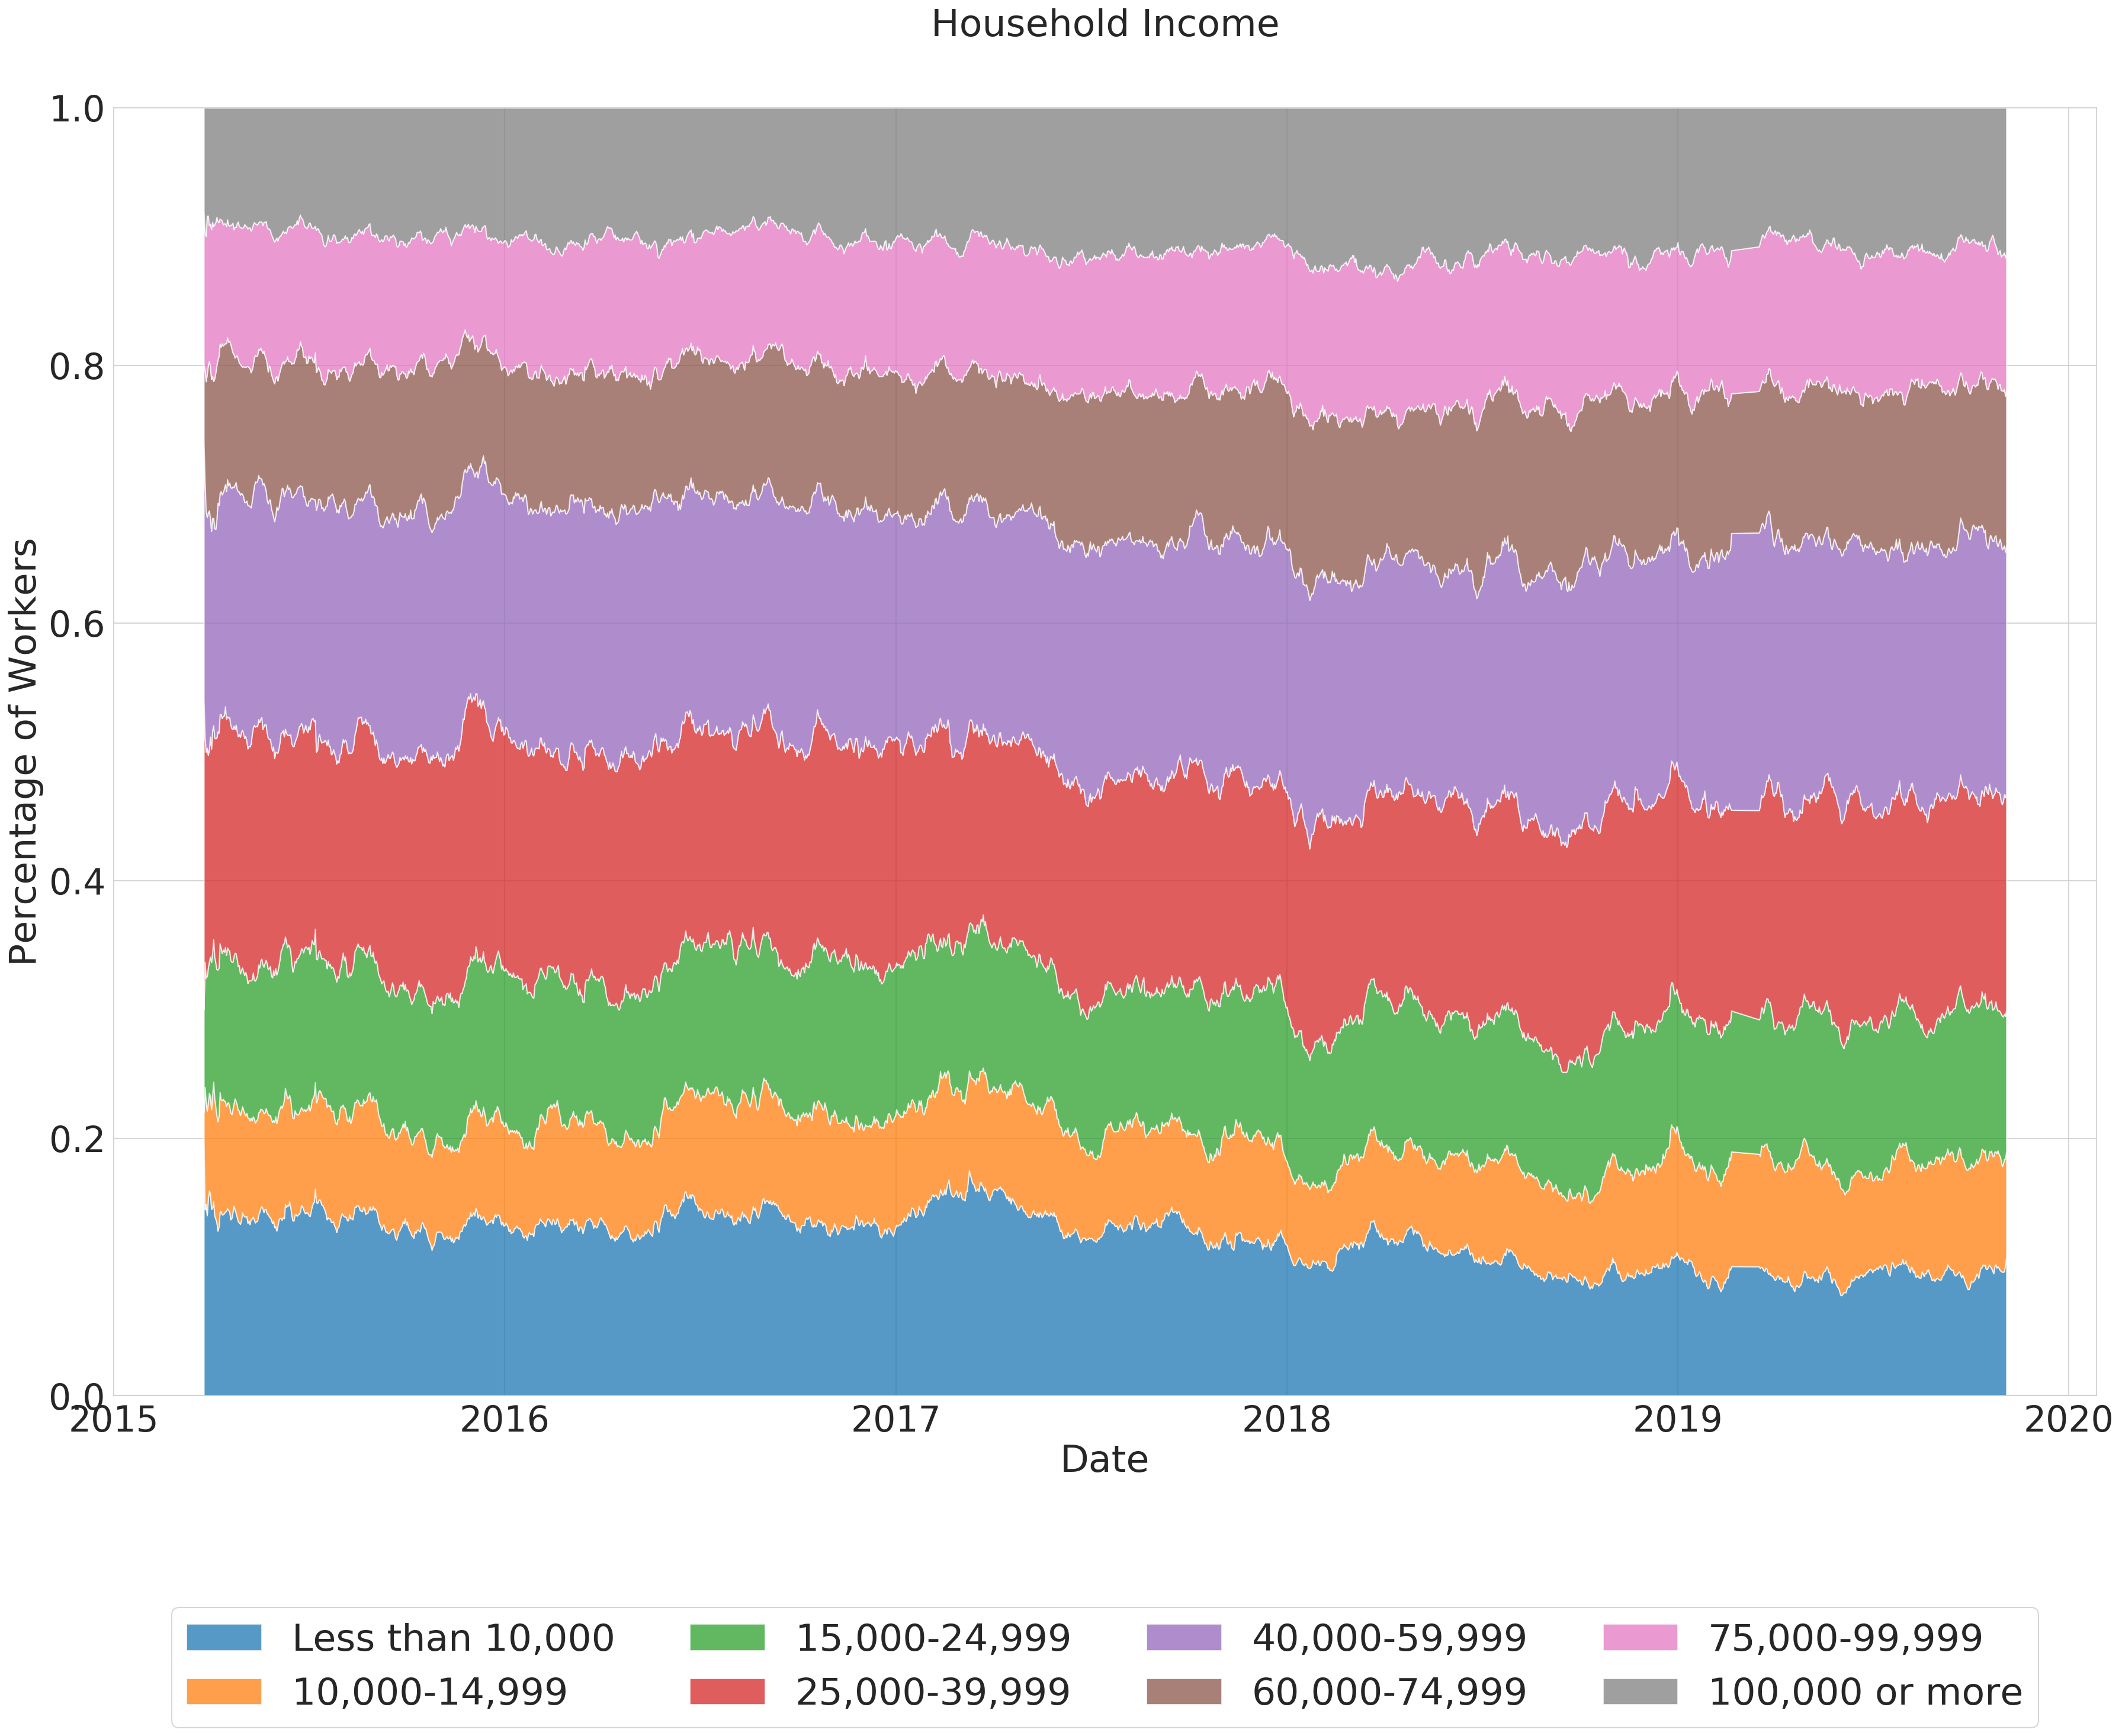

In [90]:
fm = hhincome_table[sorted(status)].ewm(span=30).mean()
fs = hhincome_table[sorted(status)].ewm(span=30).std() 
plt.figure(figsize = (30,20))
plt.tick_params(labelsize=30)

incomes = [fm[d] for d in status]

plt.stackplot(fm.index, incomes, alpha=0.75)
plt.ylim([0.0,1.0])

ax = plt.gca()
ax.set_title("Household Income", fontsize='x-large', y=1.05)
ax.set_ylabel("Percentage of Workers", fontsize='x-large')
ax.set_xlabel("Date", fontsize='x-large')


legend = []
for stat in status:
    s = stat.replace('$','')
    legend.append(s)
    
ax.legend(legend, fontsize='x-large', fancybox=True, frameon = True, loc="upper center", ncol=4, 
         bbox_to_anchor=(0.5, -0.15))